In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap

import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [2]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-08-24') 
wave = july18.variables['VHM0'][:]

july18

<xarray.Dataset>
Dimensions:    (latitude: 47, time: 24, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-08-24 ... 2021-08-24T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-01-04 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [3]:
li = 4   # 0   4(7-5)  4   3   2  -  5   11    0    0    3        6    3   
le = 18  # 15  18    18  17    15  - 17   23   12   12   15(17)   18   15  
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i] = np.logical_xor(cost[i],binary_erosion(cost[i])) 

In [35]:
# general basemap of Italy configuration space
# mp = Basemap(projection='merc',
#              llcrnrlon=6.42,  
#              llcrnrlat=40.58, 
#              urcrnrlon=15.13, 
#              urcrnrlat=45.5488,  
#              resolution='i')

# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp(lon, lat)
# lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
# x_mask, y_mask = mp(lon_mask, lat_mask)

# x_min, y_min = mp(lons.values[0], lats.values[0]) 
# x_max, y_max = mp(lons.values[-1], lats.values[-1])   

# basemap for zoom plots
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f')

<ipython-input-5-e2c93589f9f8>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[-2], cmap=ListedColormap(['white', 'red']))


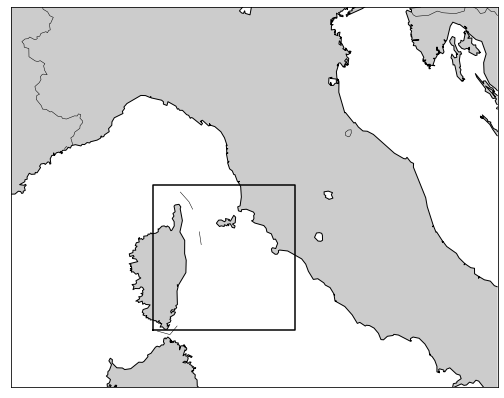

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.pcolor(x, y, cost[-2], cmap=ListedColormap(['white', 'red']))
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [6]:
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]     # contour meteo points
x_obsm2_, y_obsm2_ = [[] for i in range(le-li)], [[] for i in range(le-li)]     # contour meteo points

oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j]:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])        
            if contour_raw_meteo[i][k][j]:
                x_obsm[i].append(lons.values[j])
                y_obsm[i].append(lats.values[k])
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])           # meteo contour points
#     x_obsm2_[i], y_obsm2_[i] = mp2(x_obsm[i], y_obsm[i])        # meteo contour points
    oxmeteo_[i], oymeteo_[i] = mp(oxmeteo[i], oymeteo[i])       # meteo points
    
# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 9.6:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
    
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points
# x_obsl2_, y_obsl2_ = mp2(x_obsl, y_obsl)       # coastline points

ox_a_list = [[] for i in range(le-li)]
oy_a_list = [[] for i in range(le-li)]
for i in range(le-li):
    for j, _ in enumerate(x_obsm[i]):
        ox_a_list[i].append(x_obsm[i][j])
        oy_a_list[i].append(y_obsm[i][j])
    for k, _ in enumerate(x_obsl):
        ox_a_list[i].append(x_obsl[k])
        oy_a_list[i].append(y_obsl[k])

In [7]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]  # 9.41
sy = yspace[7]  # 43.104168
gx = xspace[50]   # 11.291668   #29  50  39
gy = yspace[28]   # 42.520832   #37  28  33    9 per giorno 10, 8 per giorno 11

sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

In [8]:
grid_size = 0.04166
robot_radius = grid_size

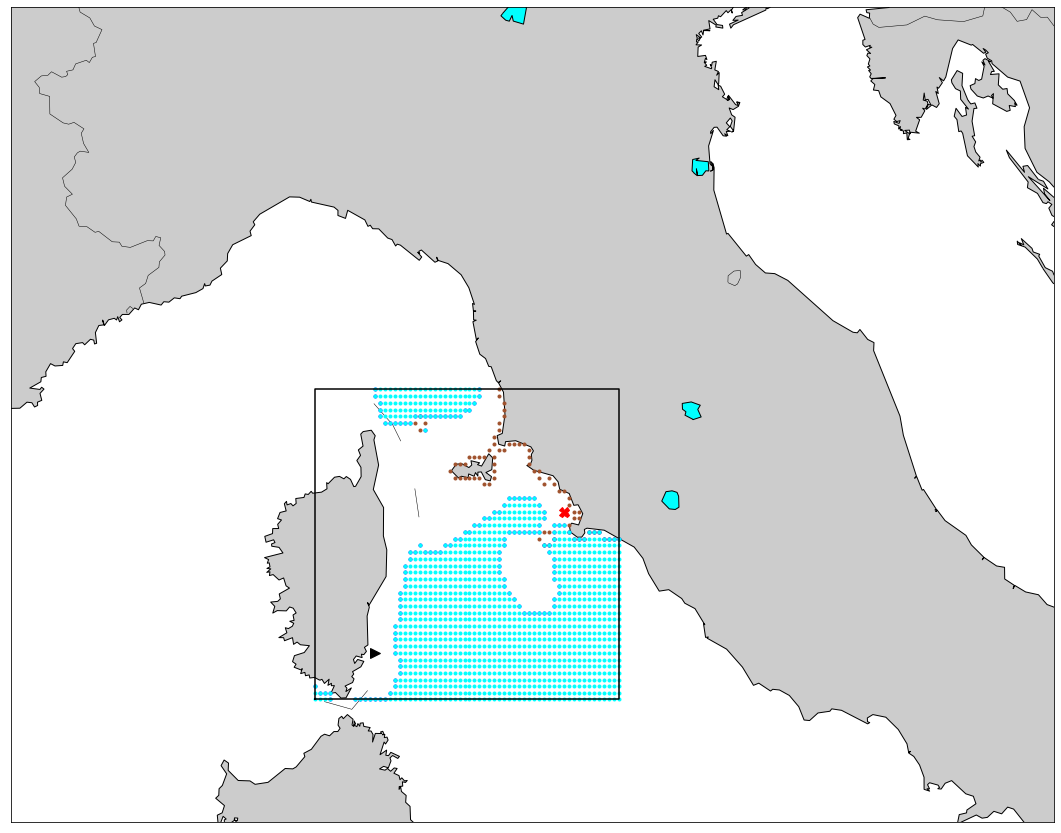

In [11]:
i = 0
plt.figure(1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_[i], y_obsm_[i], '.', color="b")
plt.plot(oxmeteo_[i], oymeteo_[i], '.', color="aqua")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [2000]:
# local_x, local_y = [], []  
# local_x_, local_y_ = [], [] 
# local_x2, local_y2 = [], []  
# local_x_2, local_y_2 = [], [] 
# # astar_contour = np.zeros_like(wave[:le])
# image = np.zeros((47, 62))

# for i in range(le-li):
#     for k in np.arange(0,47,1):
#         for j in np.arange(0,62,1):
#             if cost[i][k][j] == 100:
#                 geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
#                 if 18*(i) < geo_dist < 18*(i+1):
#                     local_x.append(lons.values[j])
#                     local_y.append(lats.values[k]) 
#                     image[k][j] = 1

# local_x_, local_y_ = mp(local_x, local_y)       # map contour points        

# astar_contour = np.logical_xor(image,binary_erosion(image)) 
# for k in np.arange(0,47,1):
#         for j in np.arange(0,62,1):
#             if astar_contour[k][j]:
#                 local_x2.append(lons.values[j])
#                 local_y2.append(lats.values[k]) 
# local_x_2, local_y_2 = mp(local_x2, local_y2)       # map contour points     



In [2001]:
# for i in range(len(meteo[5])):
#     if np.allclose([list_sx[4],list_sy[4]], meteo[5][i], atol=0.001):
#         print(True)

In [12]:
meteo = [[] for i in range(le-li)]
for i in range(le-li):
    for j in range(len(oxmeteo[i])):
        meteo[i].append([oxmeteo[i][j],oymeteo[i][j]])

In [86]:
# ox_a_listnoob = [[0] for i in range(le-li)]
# oy_a_listnoob = [[0] for i in range(le-li)]
# a_star = AStarPlanner(ox_a_listnoob, oy_a_listnoob, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
# rxnoob, rynoob = a_star.planning(sx, sy, gx, gy)
# rxnoob = list(reversed(rxnoob))
# rynoob = list(reversed(rynoob))
# rxnoob_, rynoob_ = mp(rxnoob, rynoob)

In [322]:
# q = rx_list[-1].index(sx)
# while path_dist < 18*(k+1): # km
#     if np.hypot(rx_list[-1][q] - gx, ry_list[-1][q] - gy) <= grid_size:
#         print("Complete travel in less than {} hours".format(k+1))
#         dist = np.hypot(rx_list[-1][q] - gx, ry_list[-1][q] - gy)
#         break
#     path_dist += distance(lonlat(*(rx_list[-1][q],ry_list[-1][q])), lonlat(*(rx_list[-1][q+1],ry_list[-1][q+1]))).km
#     # to be conservative I rather use future time window than starting in the future with a past map
#     if path_dist > 18*(k+1):  
#         path_dist -= distance(lonlat(*(rx_list[-1][q],ry_list[-1][q])), lonlat(*(ry_list[-1][q+1],ry_list[-1][q+1]))).km
#         path_dist_list.append(path_dist)
#         break 
#     q += 1
# sx = rx_list[-1][q]
# sy = ry_list[-1][q]
# list_sx.append(sx)
# list_sy.append(sy)

In [13]:
rx_list = []
ry_list = []
rx_list_finale = []
ry_list_finale = []
k = 0
q_count = 0
path_dist = 0
path_dist_list = []
list_sx = []
list_sy = []
list_sx.append(sx)
list_sy.append(sy)
dist = np.hypot(sx - gx, sy - gy)
var1 = True


In [14]:
start_time = time.time()
while dist >= grid_size:
    path_cost = 0 
#     if k == 0:
#         a_star = AStarPlanner([0], [0], grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
#         rx, ry = a_star.planning(sx, sy, gx, gy)
#         rx = list(reversed(rx))
#         ry = list(reversed(ry))
#         for i in range(len(rx)-1):
#             path_cost += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
#         print("Travel distance = {} km".format(path_cost))
        
#         q = 0
#         while path_dist < 18*(k+1): # km
#             if np.hypot(rx[q] - gx, ry[q] - gy) <= grid_size:
#                 print("Complete travel in less than {} hours".format(k+1))
#                 dist = np.hypot(rx[q] - gx, ry[q] - gy)
#                 break
#             path_dist += distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km

#             # to be conservative I rather use future time window than starting in the future with a past map
#             if path_dist > 18*(k+1):  
#                 path_dist -= distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
#                 path_dist_list.append(path_dist)
#                 break 
#             q += 1

#         sx = rx[q]
#         sy = ry[q]
#         list_sx.append(sx)
#         list_sy.append(sy)
#         rx_list.append(rx)
#         ry_list.append(ry)
#         rx_list_finale.extend(rx[:q])
#         ry_list_finale.extend(ry[:q])
#     else:
    a_star = AStarPlanner(ox_a_list[k], oy_a_list[k], grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
    rx, ry = a_star.planning(sx, sy, gx, gy)
    rx = list(reversed(rx))
    ry = list(reversed(ry))

    for i in range(len(rx)-1):
        path_cost += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
    print("Travel distance = {} km".format(path_cost))

    if len(ry) == 1:
        print("The algorithm does not found a path because of rough sea in between or in the survey area")
#         plt.figure(1, figsize=(20, 15))
#         mp.plot(sx_init, sy_init, ">k", markersize=10)
#         mp.plot(sx_a, sy_a, ".k", markersize=5)
#         mp.plot(gx_a, gy_a, "Xr", markersize=10)
#         plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
#         plt.plot(x_obsm_[k], y_obsm_[k], '.', color="dodgerblue")
#         mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#         mp.drawcoastlines()
#         mp.drawstates()
#         mp.drawcountries()
#         plt.show()

        q_init = rx_list[-1].index(sx)
        q = rx_list[-1].index(sx)
        while path_dist < 18*(k+1): # km
            if np.hypot(rx_list[-1][q] - gx, ry_list[-1][q] - gy) <= grid_size:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(rx_list[-1][q] - gx, ry_list[-1][q] - gy)
                break
            path_dist += distance(lonlat(*(rx_list[-1][q],ry_list[-1][q])), lonlat(*(rx_list[-1][q+1],ry_list[-1][q+1]))).km
            # to be conservative I rather use future time window than starting in the future with a past map
            if path_dist > 18*(k+1):  
                path_dist -= distance(lonlat(*(rx_list[-1][q],ry_list[-1][q])), lonlat(*(rx_list[-1][q+1],ry_list[-1][q+1]))).km
                path_dist_list.append(path_dist)
                break 
            q += 1

        sx = rx_list[-1][q]
        sy = ry_list[-1][q]
        list_sx.append(sx)
        list_sy.append(sy)
        rx_list.append(rx_list[-1])  # resave the same path
        ry_list.append(ry_list[-1])
        rx_list_finale.extend(rx_list[-1][q_init:q])
        ry_list_finale.extend(ry_list[-1][q_init:q])
    else:
        q = 0
        while path_dist < 18*(k+1): # km
            if np.hypot(rx[q] - gx, ry[q] - gy) <= grid_size:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(rx[q] - gx, ry[q] - gy)
                break
            path_dist += distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km

            # to be conservative I rather use future time window than starting in the future with a past map
            if path_dist > 18*(k+1):  
                path_dist -= distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
                path_dist_list.append(path_dist)
                break 
            q += 1

        sx = rx[q]
        sy = ry[q]
        list_sx.append(sx)
        list_sy.append(sy)
        rx_list.append(rx)
        ry_list.append(ry)
        rx_list_finale.extend(rx[:q])
        ry_list_finale.extend(ry[:q])

    dist = np.hypot(sx - gx, sy - gy)
    sx_a, sy_a = mp(sx, sy)
    rx_, ry_ = mp(rx, ry)    

    k += 1
    for i in range(len(meteo[k])):
        if np.allclose([sx,sy], meteo[k][i], atol=0.0005, rtol=0.0005):
            print(True)
            rx_list_finale.append(rx[q])
            ry_list_finale.append(ry[q])
            print("USV got lost")
            var1 = False
            break
    if var1:
        print("USV in safe zone")
    else:
        break
print("Computational time is {}".format(time.time() - start_time))

min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Travel distance = 220.7978903154468 km
USV in safe zone
min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Travel distance = 199.99862809081202 km
USV in safe zone
min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Travel distance = 176.90086454168153 km
USV in safe zone
min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Travel distance = 145.7357856845477 km
USV in safe zone
min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Travel distance = 126.16949515643702 km
USV in safe zone
min_x: 8.9583339691162

In [ ]:
# sx = xspace[12]  # 9.41
# sy = yspace[7]  # 43.104168
# gx = xspace[50]   # 11.291668
# gy = yspace[28]   # 42.520832

# sx_init, sy_init = mp(sx, sy)
# gx_a, gy_a = mp(gx, gy)

# rx_list = []
# ry_list = []
# rx_list_finale = []
# ry_list_finale = []
# k = 0
# q_count = 0
# path_dist = 0
# path_dist_list = []
# list_sx = []
# list_sy = []
# list_sx.append(sx)
# list_sy.append(sy)

# dist = np.hypot(sx - gx, sy - gy)
# start_time = time.time()
# while dist >= grid_size:
#     path_cost = 0    
#     if temp_var: 
#         ox_temp = x_obsl + x_obsm[k] + x_obsm[k+1]
#         oy_temp = y_obsl + y_obsm[k] + y_obsm[k+1]
#         a_star = AStarPlanner(ox_temp, oy_temp, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
#         rx, ry = a_star.planning(sx, sy, gx, gy)
#         rx = list(reversed(rx))
#         ry = list(reversed(ry))   
#     else:
#         a_star = AStarPlanner(ox_a_list[k], oy_a_list[k], grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
#         rx, ry = a_star.planning(sx, sy, gx, gy)
#         rx = list(reversed(rx))
#         ry = list(reversed(ry))
    
#     for i in range(len(rx)-1):
#         path_cost += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
#     print("Travel distance = {} km".format(path_cost))
    
#     if len(ry) == 1:  # means A* does not found the route
#         print("The algorithm does not found a path")
#         plt.figure(1, figsize=(20, 15))
#         mp.plot(sx_init, sy_init, ">k", markersize=10)
#         mp.plot(sx_a, sy_a, ".k", markersize=5)
#         mp.plot(gx_a, gy_a, "Xr", markersize=10)
#         plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
#         plt.plot(x_obsm_[k], y_obsm_[k], '.', color="dodgerblue")
#         mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#         mp.drawcoastlines()
#         mp.drawstates()
#         mp.drawcountries()
#         plt.show()
#         k += 1
        
#     else:
#         q = 0
#         while path_dist < 18*(k+1): # km
#             if np.hypot(rx[q] - gx, ry[q] - gy) <= grid_size:
#                 print("Complete travel in less than {} hours".format(k+1))
#                 dist = np.hypot(rx[q] - gx, ry[q] - gy)
#                 break
#             path_dist += distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
#             # to be conservative I rather use future time window than starting in the future with a past map
#             if path_dist > 18*(k+1):  
#                 path_dist -= distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
#                 path_dist_list.append(path_dist)
#                 break 
#             q += 1
#         # I must use index q as new start
#         sx = rx[q]
#         sy = ry[q]
#         print(rx[:q])
#         print(ry[:q])
#         print(sx,sy)
#         list_sx.append(sx)
#         list_sy.append(sy)

#         q_count += q
#         dist = np.hypot(sx - gx, sy - gy)

#         sx_a, sy_a = mp(sx, sy)
        
#         rx_, ry_ = mp(rx, ry)
#         plt.figure(1, figsize=(20, 15))
#         mp.plot(sx_init, sy_init, ">k", markersize=10) 
#         mp.plot(sx_a, sy_a, ".k", markersize=5)
#         mp.plot(gx_a, gy_a, "Xr", markersize=10)
#         plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
#         plt.plot(x_obsm_[k], y_obsm_[k], '.', color="dodgerblue")
#         mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#         mp.plot(rx_, ry_, '-r')
#         mp.drawcoastlines()
#         mp.drawstates()
#         mp.drawcountries()
#         plt.show()
#         k += 1
#         if [int(round(sx,3)*1000),int(round(sy,3)*1000)] in meteo[k]:
#             print([int(round(sx,3)*1000),int(round(sy,3)*1000)] in meteo[k])
#             list_sx.pop()
#             list_sy.pop()
#             sx = list_sx[-1]
#             sy = list_sy[-1]
#             k -= 1
#             path_dist_list.pop()
#             path_dist = path_dist_list[-1]
#             temp_var = True
#         else:
#             rx_list.append(rx)
#             ry_list.append(ry)
#             temp_var = False
#             rx_list_finale.extend(rx[:q])
#             ry_list_finale.extend(ry[:q])

# # rx_list_finale.extend(rx)
# # ry_list_finale.extend(ry)
# print("Computational time is {}".format(time.time() - start_time))

In [791]:
# print([list_sx[4],list_sy[4]])
# print(meteo[4])

In [15]:
rx_list_ = np.zeros_like(rx_list)
ry_list_ = np.zeros_like(ry_list)
for i in range(len(rx_list)):
    rx_list_[i],ry_list_[i] = mp(rx_list[i],ry_list[i])
    
for i in range(len(list_sx)):
    list_sx_,list_sy_ = mp(list_sx,list_sy)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [130]:
# for i in range(len(meteo[3])):
#     if np.allclose([list_sx[3],list_sy[3]], meteo[3][i], atol=0.005,rtol=0.0003):
#         print(True)
# # print([list_sx[4],list_sy[4]])
# # print(meteo[5])



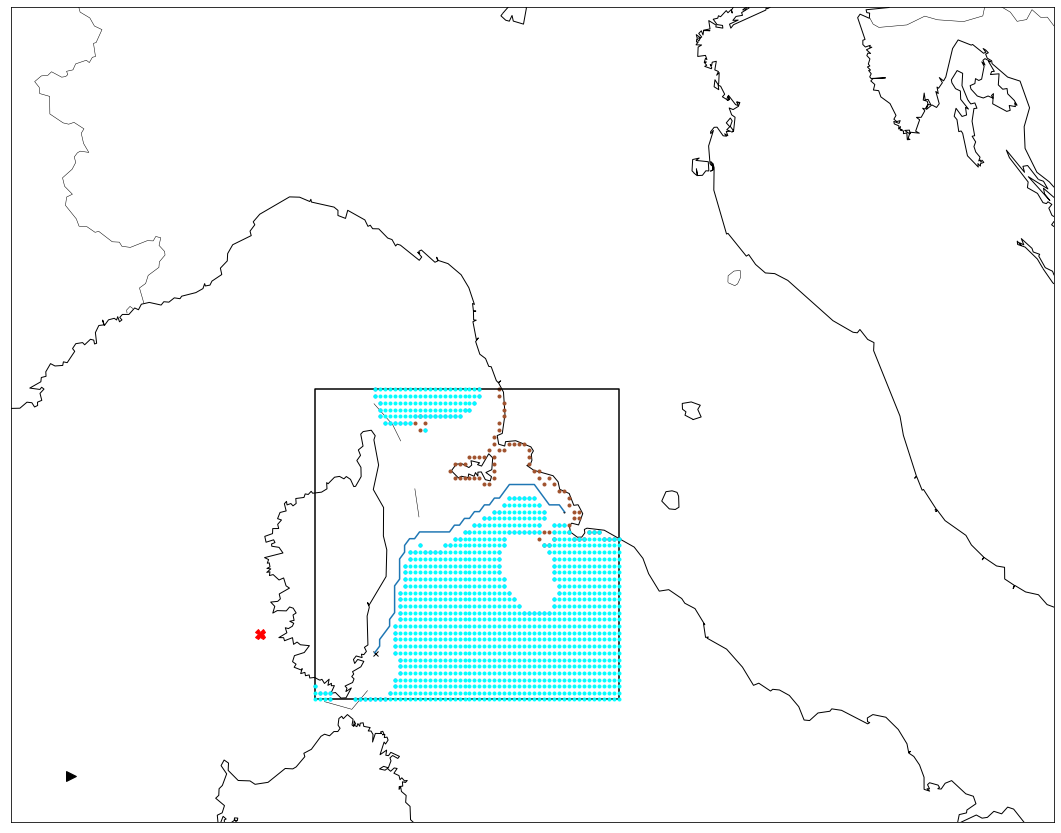

In [75]:
i =0
plt.figure(1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(sx_a, sy_a, ".k", markersize=2)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_[i], y_obsm_[i], '.', color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# for i in range(len(rx_list)): 
# plt.plot(list_sx_[i], list_sy_[i], 'xk', markersize=5)
plt.plot(oxmeteo_[i], oymeteo_[i], '.', color="aqua")
plt.plot(list_sx_[i], list_sy_[i], 'xk', markersize=5)
mp.plot(rx_list_[i], ry_list_[i], '-')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [79]:
x_obsm_2 = [[] for i in range(len(x_obsm))]
y_obsm_2 = [[] for i in range(len(y_obsm))]
for i in range(len(x_obsm)):
    x_obsm_2[i], y_obsm_2[i] = mp2(x_obsm[i], y_obsm[i])
    
oxmeteo2 = [[] for i in range(len(oxmeteo))]
oymeteo2 = [[] for i in range(len(oymeteo))]
for i in range(len(oxmeteo)):
    oxmeteo2[i], oymeteo2[i] = mp2(oxmeteo[i], oymeteo[i])
    
rx_list2 = [[] for i in range(len(rx_list))]
ry_list2 = [[] for i in range(len(ry_list))]
for i in range(len(rx_list)):
    rx_list2[i], ry_list2[i] = mp2(rx_list[i], ry_list[i])
    
list_sx2, list_sy2 = mp2(list_sx, list_sy)

In [64]:
sx = xspace[12]  # 9.41
sy = yspace[7]  # 43.104168
gx = xspace[50]   # 11.291668   #29  50  39
gy = yspace[28]   # 42.520832   #37  28  33    9 per giorno 10, 8 per giorno 11

sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

In [ ]:
plt.plot(list_sx_[i], list_sy_[i], 'xk', markersize=5)
mp.plot(rx_list_[i], ry_list_[i], '-')

In [115]:
len(list_sx2)

12

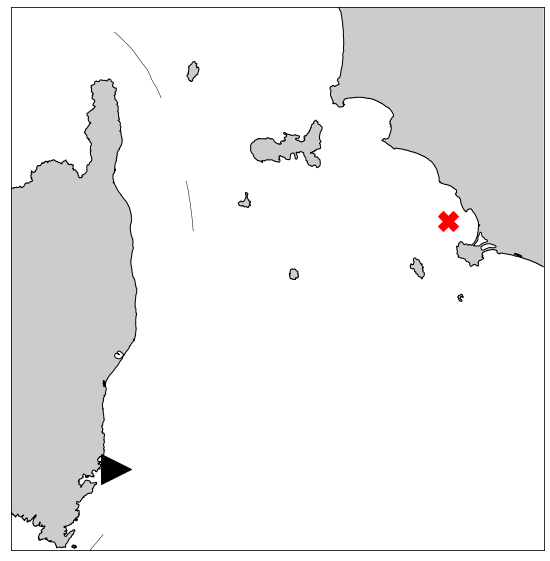

In [123]:
i=11
# for i in range(len(rx_list2)):
#     i+=1
plt.figure(1, figsize=(15, 10))
mp2.plot(sx_init, sy_init, ">k", markersize=30)
mp2.scatter(list_sx2[i], list_sy2[i], marker='x',color='k', linewidth=3, s=100)
mp2.plot(gx_a, gy_a, "Xr", markersize=20)
# mp2.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp2.scatter(oxmeteo2[i], oymeteo2[i], color="aqua")
mp2.scatter(x_obsm_2[i], y_obsm_2[i], color="dodgerblue")
# mp2.plot(rx_list2[i], ry_list2[i], '-')

mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig('imm11.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
print(rx_list_finale)
print("---------")
print(rx)
print("---------")
print(sx)

[9.45825396911621, 9.49991396911621, 9.49991396911621, 9.541573969116211, 9.583233969116211, 9.583233969116211, 9.624893969116211, 9.666553969116212, 9.666553969116212, 9.666553969116212, 9.666553969116212, 9.708213969116212, 9.708213969116212, 9.708213969116212, 9.708213969116212, 9.74987396911621, 9.79153396911621, 9.833193969116211, 9.874853969116211, 9.916513969116211, 9.958173969116212, 9.99983396911621, 10.04149396911621, 10.08315396911621, 10.124813969116211, 10.166473969116211, 10.208133969116211, 10.249793969116212, 10.291453969116212, 10.33311396911621, 10.37477396911621, 10.416433969116211, 10.458093969116211, 10.499753969116211, 10.541413969116212, 10.58307396911621, 10.62473396911621, 10.66639396911621, 10.70805396911621, 10.749713969116211, 10.791373969116211, 10.833033969116212, 10.874693969116212, 10.91635396911621, 10.95801396911621, 10.99967396911621, 11.041333969116211]
---------
[10.833033969116212, 10.874693969116212, 10.91635396911621, 10.95801396911621, 10.999673

In [33]:
# rx_list_finale.append(rx[-1])
# ry_list_finale.append(ry[-1])
rx_list_finale.append(sx)
ry_list_finale.append(sy)

In [362]:
# print([int(9.625*1000), int(41.354*1000)] in meteo[1])
# print(meteo[1][0] in meteo[1])

# meteo[1].append([9.625, 41.354])
# meteo[1].append([0,0])
# print("{:.40f}".format(int(meteo[1][0][1]*1000.0)))

In [363]:
# i = 0
# print([9.042, 41.354] in meteo[4][0:4])
# print("---------------------------")
# # print(meteo[i])
# # print([8.958, 41.354] in meteo[i])
# print(meteo[4][0:4])

# [9.042, 41.354] in meteo[4][0:4]

# # [9.583, 41.354] in meteo[i]

In [156]:
# rx_list_finale.append(list_sx[-1])
# ry_list_finale.append(list_sy[-1])

### Single path as sum of global path 

In [32]:
hh = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(6.42,45.5488))).m / mp(15.13,45.5488)[1])
ww = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(15.13,40.58))).m / mp(15.13,45.5488)[0])

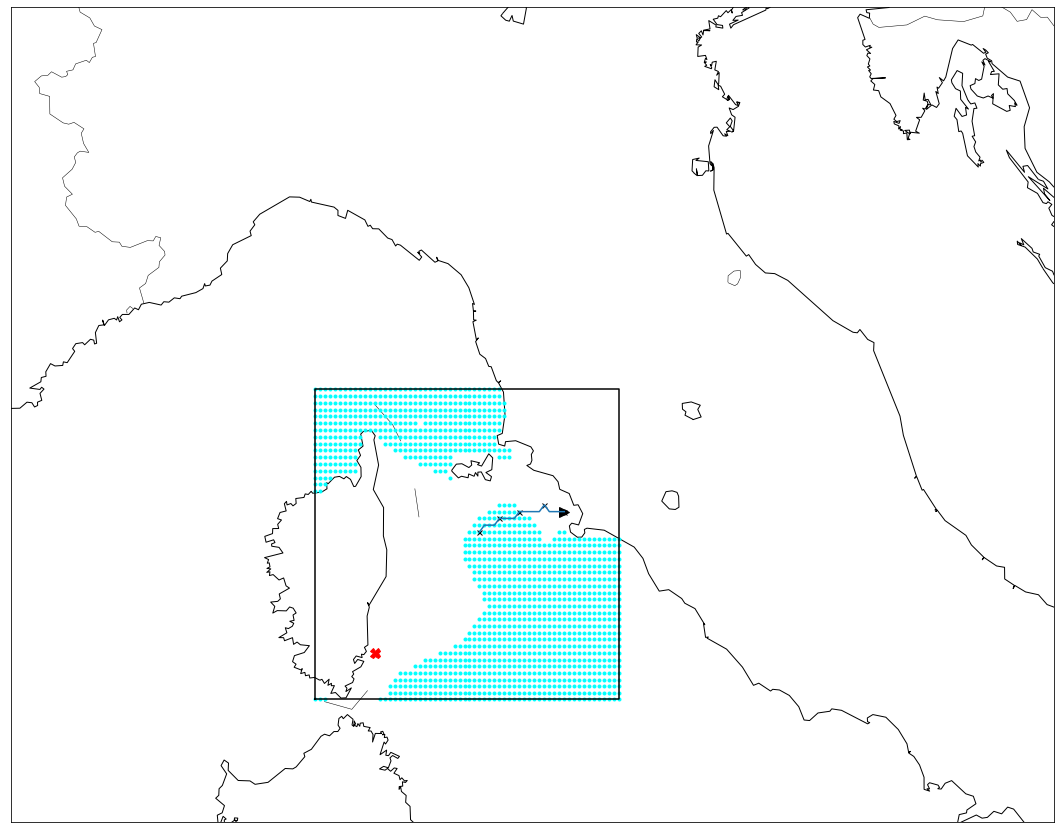

In [25]:
import matplotlib.patches as pltpat
i =0
rx_list_finale_, ry_list_finale_ = mp(rx_list_finale, ry_list_finale)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
# mp.plot(sx_a, sy_a, ".k", markersize=5)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(oxmeteo_[i], oymeteo_[i], '.', color="aqua")
# mp.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'red']))
# plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(list_sx_, list_sy_, 'xk', markersize=5)
# plt.plot(templistx, templisty, 'xk', markersize=5)
plt.plot(list_sx_[i], list_sy_[i], 'ok', markersize=5)
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_list_finale_, ry_list_finale_, '-')
#mp.plot(rx_list_[i], ry_list_[i], '-')
# plt.scatter(local_x_2, local_y_2, color="dodgerblue")
# mp.plot(rx_ob[0], ry_ob[0], "Xr", markersize=10)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [269]:

temp =  rx_list_finale[:rx_list_finale.index(rx_ob[0])+1]
temp2 = ry_list_finale[:rx_list_finale.index(rx_ob[0])+1]

templistx = list_sx[:5]
templisty = list_sy[:5]
templistx.append(rx_ob[0])
templisty.append(ry_ob[0])
# temp


In [268]:
rx_ob = []
ry_ob = []
for i in range(len(local_x2)):              
    for j in range(len(rx_list_finale)):
        if np.allclose([rx_list_finale[j],ry_list_finale[j]], [local_x2[i], local_y2[i]], atol=0.0001, rtol=0.0001): # tune parameters 0.02058
            print(True)  
            rx_ob.append(rx_list_finale[j])
            ry_ob.append(ry_list_finale[j])
            
# print(ry_list_finale_)
# print("----------")
# print(rx_list_finale_)

# print(rx_ob, ry_ob)

True
True


In [1440]:
path_dist = 0
for i in range(len(rx_list_finale)-1):
    path_dist += distance(lonlat(*(rx_list_finale[i],ry_list_finale[i])), lonlat(*(rx_list_finale[i+1],ry_list_finale[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  9.9917 hours


In [515]:
# glopatha1neww = [[] for i in range(12)]
# glopatha2neww = [[] for i in range(12)]

# ast_list_s1neww = [[] for i in range(12)] 
# ast_list_s2neww = [[] for i in range(12)]  
# glopatha50 = [[] for i in range(12)]
# glopatha39 = [[] for i in range(12)]
# ast_list_s50 = [[] for i in range(12)] 
# ast_list_s39 = [[] for i in range(12)]  
list_sy

[42.520832,
 42.56230793823242,
 42.68728793823242,
 42.72894793823242,
 42.68728793823242,
 42.60396793823242,
 42.47898793823242,
 42.39566793823242,
 42.27068793823242,
 42.10404793823242,
 41.97906793823242,
 41.854087938232425,
 41.729168]

In [1442]:
glopatha50[11] = [rx_list_finale,ry_list_finale]
ast_list_s50[11] = [list_sx,list_sy] 

In [646]:
glopatha39[11] = [rx_list_finale,ry_list_finale]
ast_list_s39[11] = [list_sx,list_sy] 

In [272]:
# glopatha1neww[0] = [temp, temp2]
# ast_list_s1neww[0] = [templistx, templisty]  

In [126]:
glopatha1 = [[] for i in range(5)]  # 5 for 5 day missions
glopatha2 = [[] for i in range(5)]

ast_list_s1 = [[] for i in range(5)]  # 5 for 5 day missions
ast_list_s2 = [[] for i in range(5)]  # 5 for 5 day missions

In [842]:
# glo_ast1[4] = [rx_list_finale,ry_list_finale]
# ast_list_s1[4] = [list_sx,list_sy]

In [503]:
# ast_list_s2.append([list_sx,list_sy])
# glo_ast2.append([rx_list_finale,ry_list_finale])

In [1444]:
import pickle
file_name = "glopatha50.pkl"
open_file = open(file_name, "wb")
pickle.dump(glopatha50, open_file)
open_file.close()

# file_name = "glo_ast2.pkl"
# open_file = open(file_name, "rb")
# glo_ast2 = pickle.load(open_file)
# open_file.close()

## global RRT* (no prediction)

In [2076]:
try:
    from rrt_netcdf import RRT
except ImportError:
    raise

show_animation = False


class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0  # taking into account the cost

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 c_spacex,
                 c_spacey,
                 k,
                 connect_circle_dist,
                 expand_dis,
                 speed,
                 path_resolution,
                 goal_sample_rate,
                 max_iter=1000, # 1000 per giorno5
                 # RRT* parameter: planning constant for the recomputing of the cost
                 search_until_max_iter=False):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, c_spacex, c_spacey, k, expand_dis, speed, path_resolution,
                         goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """
        v = 0
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
            near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
            new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis

            # adding cost from the near node and random node
            temp1 = mp(near_node.x, near_node.y, inverse=True)
            temp2 = mp(new_node.x, new_node.y, inverse=True)
            new_node.cost = near_node.cost + distance(lonlat(*temp1), lonlat(*temp2)).m

            # new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)
            if self.check_collision(new_node, self.obstacle_list[self.k]):
                near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
                node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)
            # mp(new_node.x, new_node.y, inverse=True)

            """if new_node.cost/5 > 3600*self.k:  # comment if global planning
                self.k += 1"""

                # if self.k > 14:
                #    self.k = 14

            if animation:
                v = self.draw_graph(self.obstacle_list[self.k], v, rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index), new_node.cost, i

        print("reached max iteration")

        last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and the tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:  # in a for loop
            near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
            t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
            if t_node and self.check_collision(t_node, self.obstacle_list[self.k]):
                costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
            else:  # costs is a list
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
        new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        #  compute the distance of each node from the goal
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        #  if the distance if smaller than expand dis -> add the relative index to the goal_inds list
        goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list[self.k]):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the tree that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than expand_dist
#         if hasattr(self, 'expand_dis'):
#             r = max(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]  # compute distance of each node from the new_node
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds  # returns the index list of those points with a distance smaller than the ball radius

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            # calc the cost as distance from node with new parent and nodes in the ball
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list[self.k])
            improved_cost = near_node.cost > edge_node.cost  # can be True or False

            if no_collision and improved_cost:  # if True change near node with edge node
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        #d, _ = self.calc_distance_and_angle(from_node, to_node)
        temp1 = mp(from_node.x, from_node.y, inverse=True)
        temp2 = mp(to_node.x, to_node.y, inverse=True)
        d = distance(lonlat(*temp1), lonlat(*temp2)).m
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [2088]:
sx = xspace[39]  
sy = yspace[33] 
gx = xspace[12]   # 50
gy = yspace[7]   # 28
sx_init, sy_init = mp(sx, sy)
sx_a, sy_a = sx_init, sy_init
gx_a, gy_a = mp(gx, gy)
grid_size = 4500

obstacle_list = [[] for i in range(le-li)]
# obstacle_listk0 = [[] for i in range(le-li)]
for i in range(le-li):
    for j, _ in enumerate(x_obsm_[i]):
        obstacle_list[i].append([x_obsm_[i][j], y_obsm_[i][j], grid_size])
    for k, _ in enumerate(x_obsl_):
        obstacle_list[i].append([x_obsl_[k], y_obsl_[k], grid_size])  
#     obstacle_listk0[i].append([0, 0, grid_size])
        
# obstacle_list2 = [[] for i in range(le-li)]

# for i in range(le-li):
#     for j, _ in enumerate(x_obsm_[i]):
#         obstacle_list2[i].append([x_obsm2_[i][j], y_obsm2_[i][j], grid_size])
#     for k, _ in enumerate(x_obsl_):
#         obstacle_list2[i].append([x_obsl2_[k], y_obsl2_[k], grid_size])  

coordx_list = []
coordy_list = []

path_dist = 0
path_dist_list = []
dist = np.hypot(sx - gx, sy - gy)
grid_sizecoord = 0.04166
k = 0
rx_list_finalerrt = []
ry_list_finalerrt = []
path_star_coords = []
list_sxrrt = []
list_syrrt = []
list_sxrrt.append(sx)
list_syrrt.append(sy)
var1 = True

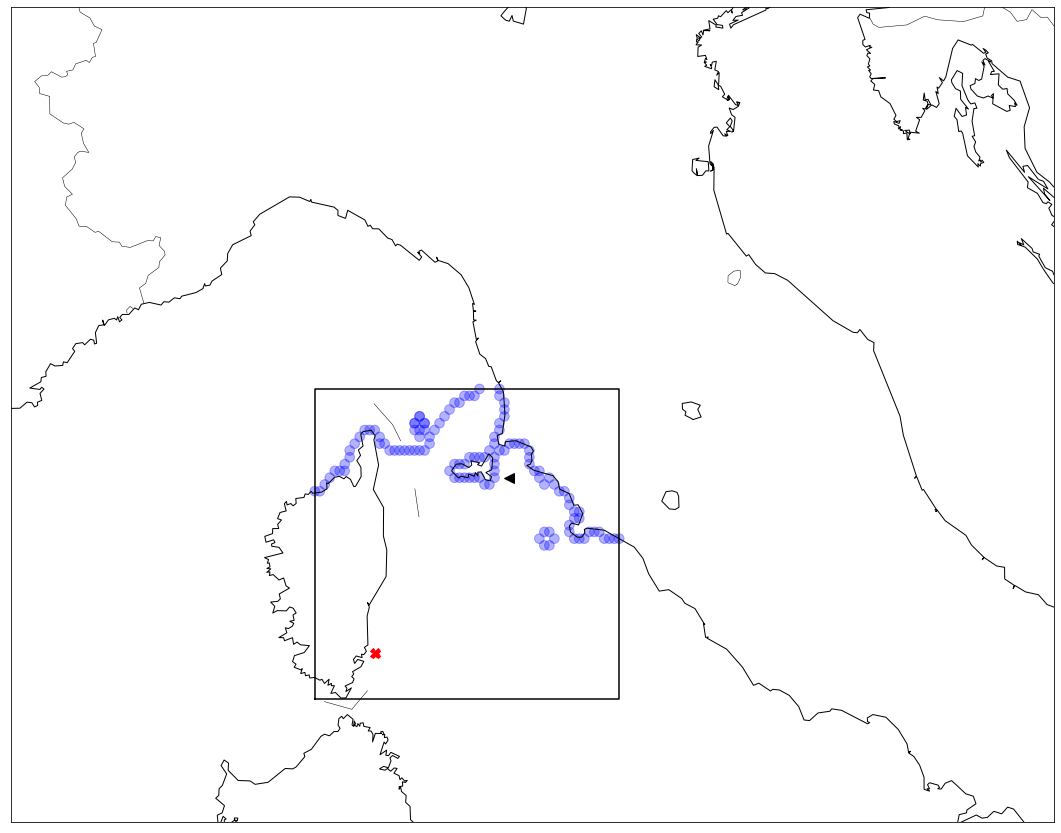

In [2089]:
k =0
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, "<k", markersize=10)
mp.plot(sx_a, sy_a, ".k", markersize=5)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obstacle_list[k])):
    ax.add_patch(plt.Circle(xy=(obstacle_list[k][i][0], obstacle_list[k][i][1]), radius=4500,
                            color='b', alpha=0.3))
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# for i in range(len(coordx_list)): 
# plt.plot(list_sxrrt_[k], list_syrrt_[k], 'xk', markersize=5)
# mp.plot(coordx_list_[k], coordy_list_[k], '-')
# plt.plot(oxmeteo_[k], oymeteo_[k], '.', color="aqua")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()
k = 0

In [1947]:
# k = 0
# rrt_star = RRTStar(
#         start=[sx_a, sy_a],
#         goal=[gx_a, gy_a],
#         rand_area=[x_min, x_max, y_min, y_max],
#         obstacle_list=obstacle_list,
#         c_spacex = Cspacex_,
#         c_spacey = Cspacey_,
#         k=k,
#         speed = 5,
#         path_resolution=5000.0,
#         connect_circle_dist=100000, # 100mila per global
#         goal_sample_rate=15,
#         expand_dis=5000)

# path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
# print("Found path!!")

# print("Travel time =", str(round(cost_tot/5/3600,4)), "hours")
# print("Travel distance =", str(round(cost_tot/1000,4)), "km")

In [1528]:
def sampling(fs, path): ## il path deve essere nel formato di RRT* [[x0,y0], [x1,y1], [x2,y2], ...]
    path_interp = []
    for i in range(len(path)-1): # for all path points
        p1 = path[i]        # point 1
        p2 = path[i+1]      # point 2
        xs = [p1[0],p2[0]]  # = [x1,x2]
        ys = [p1[1],p2[1]]  # = [y1,y2]
        if xs[0] == xs[1]:  # case in which x is the same (vertical movement)
            x_inter = np.array([xs[0] for i in range(fs)]) 
            if ys[0] == ys[1]: # case in which also y is the same
                y_inter = np.array([ys[0] for i in range(fs)])
            elif ys[1] < ys[0]: # case in which y2 < y1   
                y_inter = np.arange(ys[1], ys[0], np.abs((ys[1] - ys[0])) / fs)
            else:
                y_inter = np.arange(ys[0], ys[1], np.abs((ys[1] - ys[0])) / fs)
        elif xs[1] < xs[0]: # case in which x2 < x1  
            x_inter = np.arange(xs[0], xs[1], -np.abs((xs[1]-xs[0]))/fs)
            xs = [p2[0],p1[0]]
            ys = [p2[1],p1[1]]
            y_inter = np.asarray(np.interp(x_inter,xs,ys)) 
        else: # xs[1] > xs[0] normal case
            x_inter = np.arange(xs[0], xs[1], np.abs((xs[1]-xs[0]))/fs)
            y_inter = np.asarray(np.interp(x_inter,xs,ys))
        minn = 0
        if len(y_inter)>len(x_inter): # case in which they do not have the same length
            minn = x_inter
        else:
            minn = y_inter
        for ii in range(len(minn)):
            path_interp.append([x_inter[ii],y_inter[ii]])
    return path_interp

In [2090]:
start_time = time.time()
while dist >= grid_sizecoord:
#     if k==0:
#         rrt_star = RRTStar(
#                 start=[sx_a, sy_a],
#                 goal=[gx_a, gy_a],
#                 rand_area=[x_min, x_max, y_min, y_max],
#                 obstacle_list=obstacle_listk0,
#                 c_spacex = Cspacex_,
#                 c_spacey = Cspacey_,
#                 k=k,
#                 speed = 5,
#                 path_resolution=2000.0,
#                 connect_circle_dist=50000, # 100mila per global
#                 goal_sample_rate=15,
#                 expand_dis=2000)
        
#         path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
#         print("Found path!!")
        
#         print("Travel time =", str(round(cost_tot/5/3600,4)), "hours")
#         print("Travel distance =", str(round(cost_tot/1000,4)), "km")
        
#         path_star = list(reversed(path_star))
#         path_star_long = [0 for i in range(len(path_star))]
#         path_star_lat = [0 for i in range(len(path_star))]

#         for i in range(len(path_star)):
#             path_star_long[i], path_star_lat[i] = mp(path_star[i][0], path_star[i][1], inverse=True)
#         q = 0
        
#         while path_dist < 18*(k+1): # km
#             if np.hypot(path_star_long[q] - gx, path_star_lat[q] - gy) <= grid_sizecoord:
#                 print("Complete travel in less than {} hours".format(k+1))
#                 dist = np.hypot(path_star_long[q] - gx, path_star_lat[q] - gy)
#                 break
            
#             path_dist += distance(lonlat(*(path_star_long[q],path_star_lat[q])), lonlat(*(path_star_long[q+1],path_star_lat[q+1]))).km
# #             print(path_dist)
#             if path_dist > 18*(k+1):
#                 path_dist -= distance(lonlat(*(path_star_long[q],path_star_lat[q])), lonlat(*(path_star_long[q+1],path_star_lat[q+1]))).km
# #                 print(path_dist)
#                 print("path dist must be smaller than {}".format(18*(k+1)))
#                 break 
#             q += 1
#         sx = path_star_long[q]
#         sy = path_star_lat[q]   
#         list_sxrrt.append(sx)
#         list_syrrt.append(sy)
#         coordx_list.append(path_star_long)
#         coordy_list.append(path_star_lat)       
#         rx_list_finalerrt.extend(path_star_long[:q])
#         ry_list_finalerrt.extend(path_star_lat[:q])
#     else:
    try:
        rrt_star = RRTStar(
                start=[sx_a, sy_a],
                goal=[gx_a, gy_a],
                rand_area=[x_min, x_max, y_min, y_max],
                obstacle_list=obstacle_list,
                c_spacex = Cspacex_,
                c_spacey = Cspacey_,
                k=k,
                speed = 5,
                path_resolution=4000.0,
                connect_circle_dist=100000, # 100mila per global
                goal_sample_rate=15,
                expand_dis=4000)

        path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
#         if path_star is None:
#             print("Cannot find path")
#         else:
        print("Found path!!")

        print("Travel time =", str(round(cost_tot/5/3600,4)), "hours")
        print("Travel distance =", str(round(cost_tot/1000,4)), "km")

        path_star = list(reversed(path_star))
        path_star = sampling(5, path_star)

        path_star_long = [0 for i in range(len(path_star))]
        path_star_lat = [0 for i in range(len(path_star))]

        for i in range(len(path_star)):
            path_star_long[i], path_star_lat[i] = mp(path_star[i][0], path_star[i][1], inverse=True)
        q = 0

        while path_dist < 18*(k+1): # km
            if np.hypot(path_star_long[q] - gx, path_star_lat[q] - gy) <= grid_sizecoord:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(path_star_long[q] - gx, path_star_lat[q] - gy)
                break

            path_dist += distance(lonlat(*(path_star_long[q],path_star_lat[q])), lonlat(*(path_star_long[q+1],path_star_lat[q+1]))).km
#             print(path_dist)
            if path_dist > 18*(k+1):
                path_dist -= distance(lonlat(*(path_star_long[q],path_star_lat[q])), lonlat(*(path_star_long[q+1],path_star_lat[q+1]))).km
#                 print(path_dist)
                print("path dist must be smaller than {}".format(18*(k+1)))
                break 
            q += 1
        sx = path_star_long[q]
        sy = path_star_lat[q]   
        list_sxrrt.append(sx)
        list_syrrt.append(sy)
        coordx_list.append(path_star_long)
        coordy_list.append(path_star_lat)       
        rx_list_finalerrt.extend(path_star_long[:q])
        ry_list_finalerrt.extend(path_star_lat[:q])



    except TypeError:
#         k += 1
        print("Path plan failed")
        print("The algorithm does not found a path because of rough sea in between or in the survey area")
        q_init = coordx_list[-1].index(sx)
        q = coordx_list[-1].index(sx)
        while path_dist < 18*(k+1): # km
            if np.hypot(coordx_list[-1][q] - gx, coordy_list[-1][q] - gy) <= grid_sizecoord:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(coordx_list[-1][q] - gx, coordy_list[-1][q] - gy)
                break
            path_dist += distance(lonlat(*(coordx_list[-1][q],coordy_list[-1][q])), lonlat(*(coordx_list[-1][q+1],coordy_list[-1][q+1]))).km
            # to be conservative I rather use future time window than starting in the future with a past map
            if path_dist > 18*(k+1):  
                path_dist -= distance(lonlat(*(coordx_list[-1][q],coordy_list[-1][q])), lonlat(*(coordx_list[-1][q+1],coordy_list[-1][q+1]))).km
                path_dist_list.append(path_dist)
                break 
            q += 1

        sx = coordx_list[-1][q]
        sy = coordy_list[-1][q]
        list_sxrrt.append(sx)
        list_syrrt.append(sy)
        coordx_list.append(coordx_list[-1])  # resave the same path
        coordy_list.append(coordy_list[-1])
        rx_list_finalerrt.extend(coordx_list[-1][q_init:q])
        ry_list_finalerrt.extend(coordy_list[-1][q_init:q])
     
    dist = np.hypot(sx - gx, sy - gy)
    sx_a, sy_a = mp(sx, sy)
    rx_, ry_ = mp(path_star_long, path_star_lat)
    
    k += 1
    for i in range(len(meteo[k])):
        if np.allclose([sx,sy], meteo[k][i], atol=0.003, rtol=0.001):
            print(True)
            rx_list_finalerrt.append(path_star_long[q])
            ry_list_finalerrt.append(path_star_lat[q])
            print("USV got lost")
            var1 = False
            break
    if var1:
        print("USV in safe zone")
    else:
        break

        
        
# rx_list_finalerrt.extend(path_star_long)
# ry_list_finalerrt.extend(path_star_lat)
print("The computational time is " + str(round(time.time() - start_time, 4)) + " seconds")

Found path!!
Travel time = 8.6365 hours
Travel distance = 155.4567 km
path dist must be smaller than 18
USV in safe zone
Found path!!
Travel time = 7.6624 hours
Travel distance = 137.9227 km
path dist must be smaller than 36
USV in safe zone
Found path!!
Travel time = 6.7776 hours
Travel distance = 121.9967 km
path dist must be smaller than 54
USV in safe zone
Found path!!
Travel time = 5.6987 hours
Travel distance = 102.5764 km
path dist must be smaller than 72
USV in safe zone
Found path!!
Travel time = 4.6325 hours
Travel distance = 83.3846 km
path dist must be smaller than 90
USV in safe zone
Found path!!
Travel time = 3.8485 hours
Travel distance = 69.2724 km
path dist must be smaller than 108
USV in safe zone
Found path!!
Travel time = 2.9183 hours
Travel distance = 52.5287 km
path dist must be smaller than 126
USV in safe zone
Found path!!
Travel time = 1.7983 hours
Travel distance = 32.3685 km
path dist must be smaller than 144
USV in safe zone
Found path!!
Travel time = 0.8235

In [2091]:
print(ry_list_finalerrt)
print(path_star_lat)
# len(rx_list_finalerrt)
gy

[42.72916793823241, 42.701179664736394, 42.67317876894263, 42.64516525184926, 42.61713911446693, 42.58910035781886, 42.557967491589224, 42.526819084794255, 42.49565513888701, 42.464475655339626, 42.46045380726231, 42.45643170083575, 42.45240933606315, 42.44838671294776, 42.44436383149281, 42.410734706771606, 42.37708754210332, 42.34342233942064, 42.309739100682236, 42.287622940567665, 42.26549901317568, 42.24336731907821, 42.22122785885207, 42.19908063307886, 42.171389114432074, 42.14507679361817, 42.11875353262335, 42.09241933245735, 42.05517268572014, 42.01790418226998, 41.980613825058505, 41.94330161707614, 41.91603554335939, 41.88875781589801, 41.86146843589645, 41.83416740457022, 41.806854723145996, 41.786668205159216, 41.77616512102927, 41.76566031659131, 41.75515379191673, 41.74464554707719, 41.734135582144575, 41.72065773897076, 41.70717706840273, 41.69491274485763, 41.68264608230507, 41.67037708086132]
[41.70717706840273, 41.69491274485763, 41.68264608230507, 41.67037708086132

41.645832

In [2092]:
# rx_list_finalerrt.append(path_star_long[-2])
# ry_list_finalerrt.append(path_star_lat[-2])
rx_list_finalerrt.append(path_star_long[-1])
ry_list_finalerrt.append(path_star_lat[-1])

# rx_list_finalerrt.pop()
# ry_list_finalerrt.pop()

In [2093]:
list_sxrrt.pop()
list_syrrt.pop()
list_sxrrt.append(path_star_long[-1])
list_syrrt.append(path_star_lat[-1])

In [2094]:
coordx_list_ = np.zeros_like(coordx_list)
coordy_list_ = np.zeros_like(coordy_list)
for i in range(len(coordx_list)):
    coordx_list_[i],coordy_list_[i] = mp(coordx_list[i],coordy_list[i])
list_sxrrt_ = np.zeros_like(list_sxrrt)
list_syrrt_ = np.zeros_like(list_syrrt)
for i in range(len(list_sxrrt)):
    list_sxrrt_[i],list_syrrt_[i] = mp(list_sxrrt[i],list_syrrt[i])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [472]:
k=6
for i in range(len(meteo[k])):
    if np.allclose([list_sxrrt[k], list_syrrt[k]], meteo[5][i], atol=0.003, rtol=0.002):
        print(True)


True


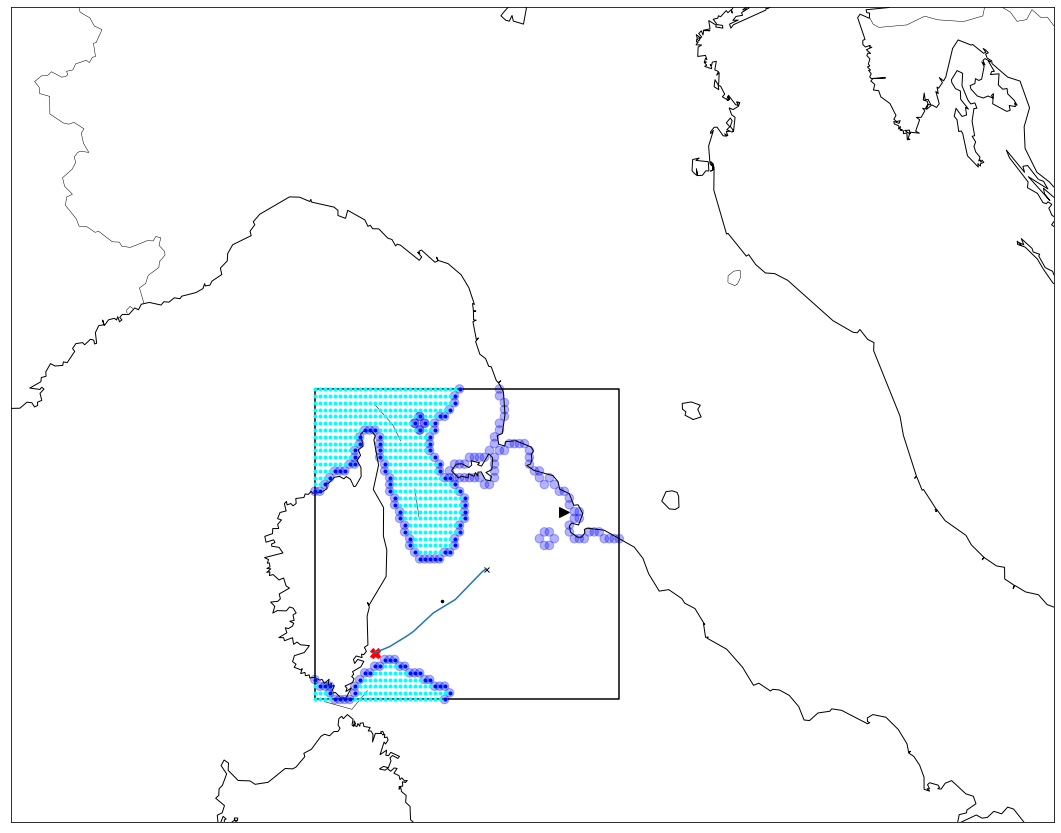

In [1898]:
k =4
# r=60
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(sx_a, sy_a, ".k", markersize=5)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obstacle_list[k])):
    ax.add_patch(plt.Circle(xy=(obstacle_list[k][i][0], obstacle_list[k][i][1]), radius=4000,
                            color='b', alpha=0.3))
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# for i in range(len(coordx_list)): 
plt.plot(list_sxrrt_[k], list_syrrt_[k], 'xk', markersize=5)
mp.plot(coordx_list_[k], coordy_list_[k], '-')
plt.plot(oxmeteo_[k], oymeteo_[k], '.', color="aqua")
plt.plot(x_obsm_[k], y_obsm_[k], '.', color="b")
# plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '.',label='RRT*')
# plt.plot(path_star[r][0], path_star[r][1], '.', markersize=10)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [2097]:
path_dist = 0
for i in range(len(rx_list_finalerrt)-1):
    path_dist += distance(lonlat(*(rx_list_finalerrt[i],ry_list_finalerrt[i])), lonlat(*(rx_list_finalerrt[i+1],ry_list_finalerrt[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  8.7742 hours


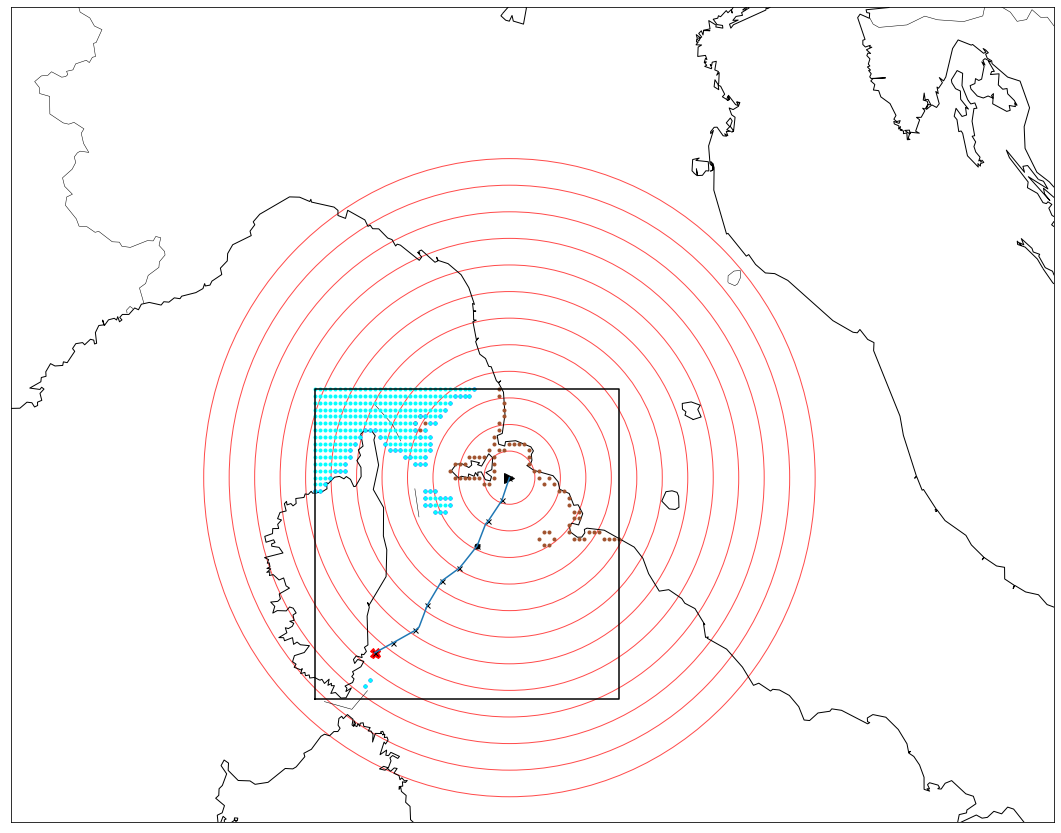

In [2095]:
rx_list_finalerrt_, ry_list_finalerrt_ = mp(rx_list_finalerrt, ry_list_finalerrt)
for i in range(len(list_sxrrt)):
    list_sxrrt_,list_syrrt_ = mp(list_sxrrt,list_syrrt)
k = 3
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(sx_a, sy_a, ".k", markersize=5)
mp.plot(gx_a, gy_a, "Xr", markersize=10)

plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_[k], y_obsm_[k], '.', color="b")
plt.plot(oxmeteo_[k], oymeteo_[k], '.', color="aqua")
plt.plot(list_sxrrt_, list_syrrt_, 'xk', markersize=5)
plt.plot(list_sxrrt_[k], list_syrrt_[k], '.k', markersize=10)
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_list_finalerrt_, ry_list_finalerrt_, '-')
# plt.plot(rx_ob, ry_ob, '.k', markersize=10)
# plt.plot(local_x_2, local_y_2, '.', color="dodgerblue")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [599]:
temp =  rx_list_finalerrt[:rx_list_finalerrt.index(rx_ob[0])+1]
temp2 = ry_list_finalerrt[:rx_list_finalerrt.index(rx_ob[0])+1]

templistx = list_sx[:7]
templisty = list_sy[:7]
templistx.append(rx_ob[0])
templisty.append(ry_ob[0])

ValueError: 337847.16373075347 is not in list

In [600]:
# glorrt1neww = [[] for i in range(12)]
# glorrt2neww = [[] for i in range(12)]

# rrt_list_s1neww = [[] for i in range(12)] 
# rrt_list_s2neww = [[] for i in range(12)] 


rx_ob = []
ry_ob = []
for i in range(len(meteo[5])):              
    for j in range(len(rx_list_finalerrt)):
        if np.allclose([rx_list_finalerrt[j],ry_list_finalerrt[j]], meteo[5][i], atol=0.0001, rtol=0.002): # tune parameters 0.02058
            print(True)  
            rx_ob.append(rx_list_finalerrt[j])
            ry_ob.append(ry_list_finalerrt[j])

In [1546]:
# glorrt50[6] = [temp, temp2]
# rrt_list_s50[6] = [templistx, templisty]

In [1545]:
# print(list_syrrt)
# print("--------")
# print(list_sxrrt)

In [1570]:
# glopathrrt50 = [[] for i in range(12)]  # 5 for 5 day missions
# glopathrrt39 = [[] for i in range(12)]

# rrt_list_s50 = [[] for i in range(12)]  # 5 for 5 day missions
# rrt_list_s39 = [[] for i in range(12)]  # 5 for 5 day missions

In [2087]:
rrt_list_s50[11] = [list_sxrrt, list_syrrt]
glopathrrt50[11] = [rx_list_finalerrt, ry_list_finalerrt]

In [2096]:
rrt_list_s39[11] = [list_sxrrt, list_syrrt]
glopathrrt39[11] = [rx_list_finalerrt, ry_list_finalerrt]

In [2101]:
# import pickle
file_name = "rrt_list_s39.pkl"
open_file = open(file_name, "wb")
pickle.dump(rrt_list_s39, open_file)
open_file.close()

# file_name = "rrt_list_s2.pkl"
# open_file = open(file_name, "rb")
# rrt_list_s2 = pickle.load(open_file)
# open_file.close()


In [112]:
mp2 = Basemap(projection='merc',
             llcrnrlon=xspace[0],  
             llcrnrlat=yspace[0], 
             urcrnrlon=xspace[-1], 
             urcrnrlat=yspace[-1],  
             resolution='f')

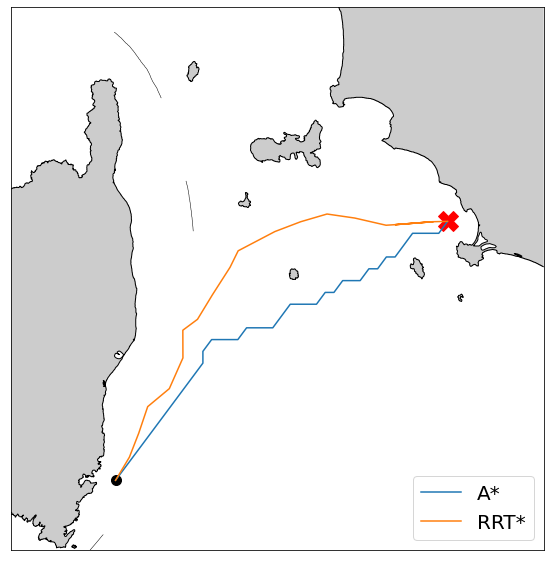

In [114]:
sx_a, sy_a = mp2(xspace[12], yspace[6])
gx_a, gy_a = mp2(xspace[50], yspace[28])

rx_list_finalerrt_, ry_list_finalerrt_ = mp2(rx_list_finalerrt, ry_list_finalerrt)
rx_list_finale_, ry_list_finale_ = mp2(rx_list_finale, ry_list_finale)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(sx_a, sy_a, ".k", markersize=20)
mp2.plot(gx_a, gy_a, "Xr", markersize=20)
mp2.plot(rx_list_finale_, ry_list_finale_, '-', label='A*')
mp2.plot(rx_list_finalerrt_, ry_list_finalerrt_, '-', label='RRT*')
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
ax.legend(prop={"size":20})
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig('exampleastarrrt.png', dpi=500)
plt.show()

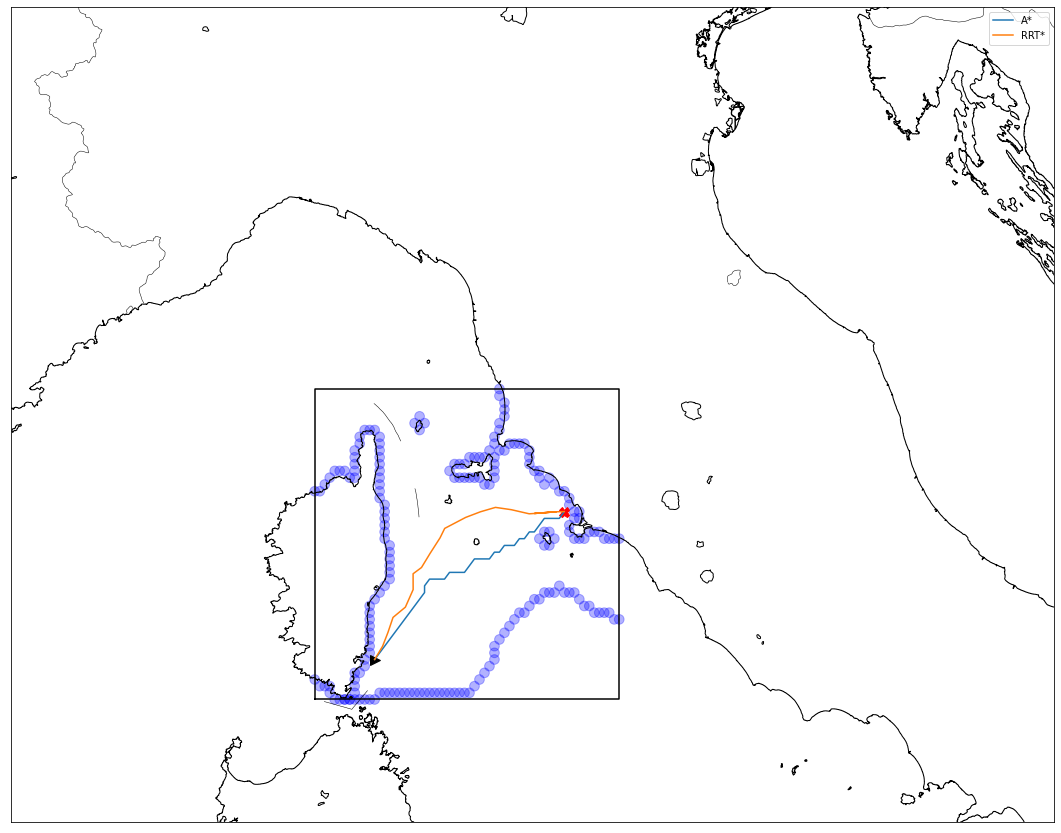

In [67]:
rx_list_finalerrt_, ry_list_finalerrt_ = mp(rx_list_finalerrt, ry_list_finalerrt)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(sx_a, sy_a, ".k", markersize=5)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_list_finale_, ry_list_finale_, '-', label='A*')
mp.plot(rx_list_finalerrt_, ry_list_finalerrt_, '-', label='RRT*')
for i in range(len(obstacle_list[k-1])):
    ax.add_patch(plt.Circle(xy=(obstacle_list[k-1][i][0], obstacle_list[k-1][i][1]), radius=4500,
                            color='b', alpha=0.3))
ax.legend()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

## APF global planning

In [28]:
import scipy.stats as st

In [67]:
l = 15
cost = np.zeros_like(wave[:l])
convex_cost = np.zeros_like(wave[:l])
contour_raw_meteo = np.zeros_like(wave[:l])
contour_raw_meteo_convex = np.zeros_like(wave[:l])
for i in range(l):
    cost[i] = 100 * (np.array(wave[i]) > 0.8)
    convex_cost[i] = convex_hull_object(cost[i])
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))
    contour_raw_meteo_convex[i]=np.logical_xor(convex_cost[i],binary_erosion(convex_cost[i]))

<ipython-input-68-a89c1dec6892>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[0], cmap=ListedColormap(['white', 'red']))


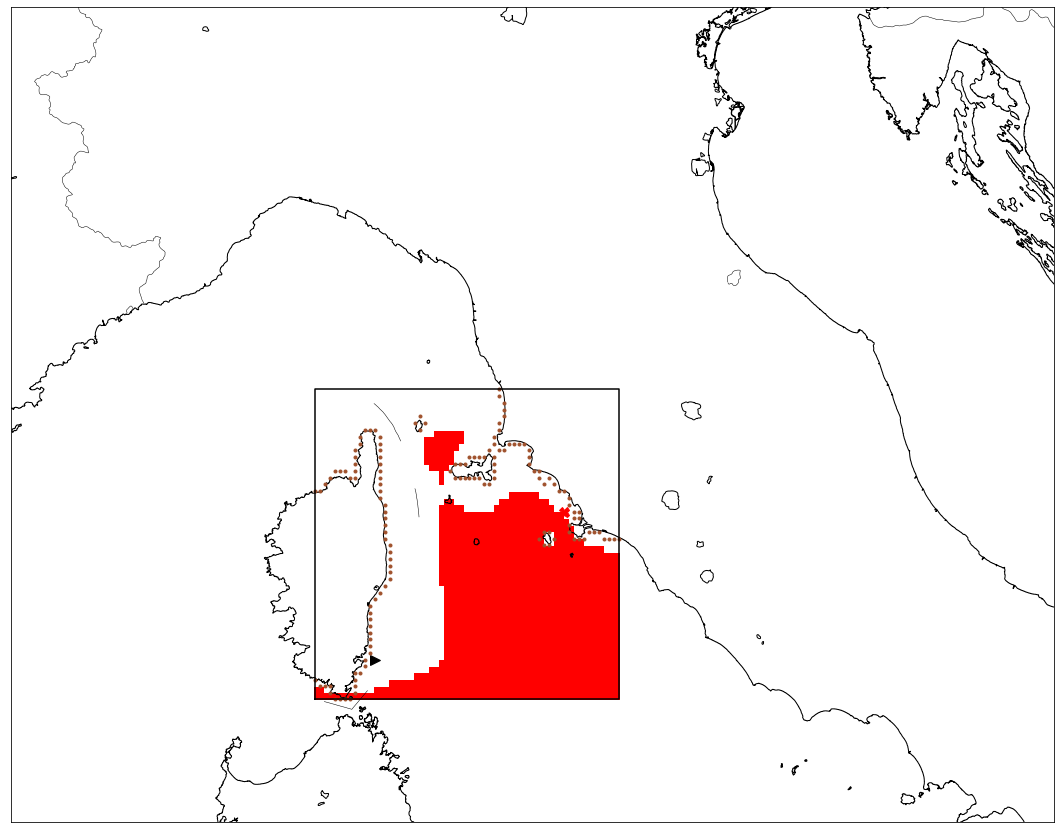

In [68]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(x, y, cost[0], cmap=ListedColormap(['white', 'red']))
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [69]:
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

oxmeteo, oymeteo = [[] for i in range(l)], [[] for i in range(l)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(l)], [[] for i in range(l)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(l)], [[] for i in range(l)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(l)], [[] for i in range(l)]     # contour meteo points

for i in range(15):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if convex_cost[i][k][j] == 1:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])
            if contour_raw_meteo_convex[i][k][j]:
                x_obsm[i].append(lons.values[j])
                y_obsm[i].append(lats.values[k])
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])       # meteo contour points
    oxmeteo_[i], oymeteo_[i] = mp(oxmeteo[i], oymeteo[i])
# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
    
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

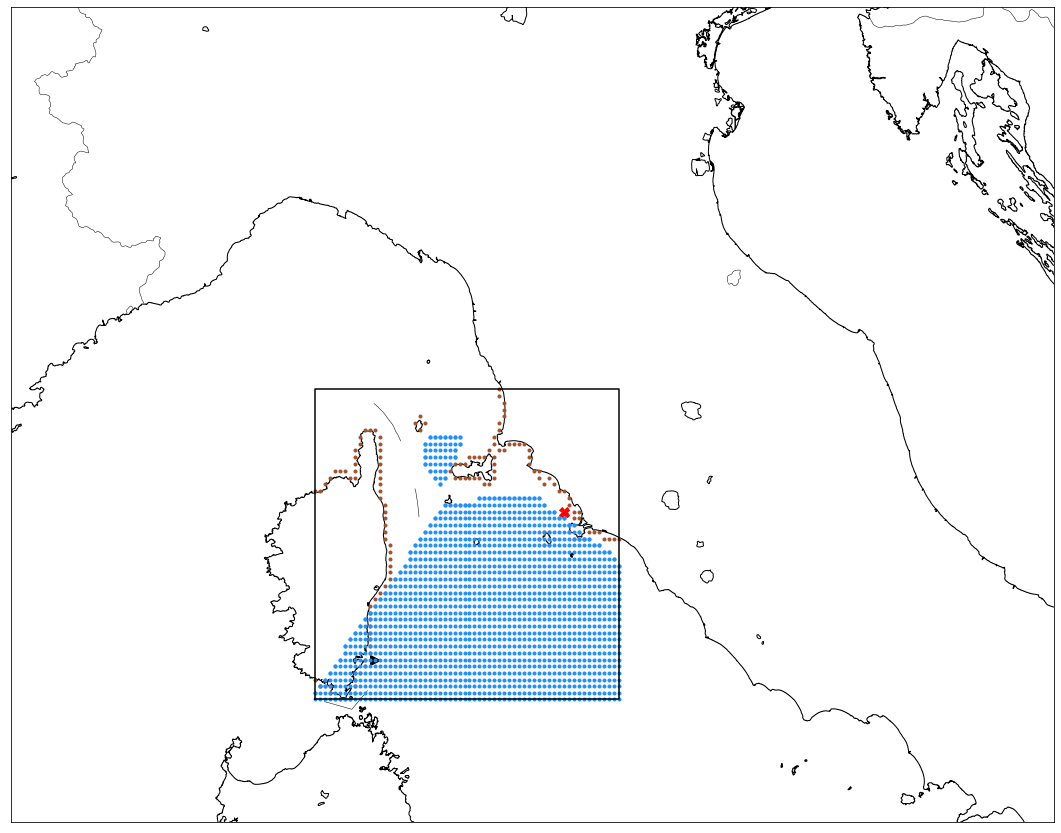

In [70]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(oxmeteo_[0], oymeteo_[0], '.', color="dodgerblue")
plt.plot(x_obsm_[0], y_obsm_[0], '.', color="dodgerblue")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

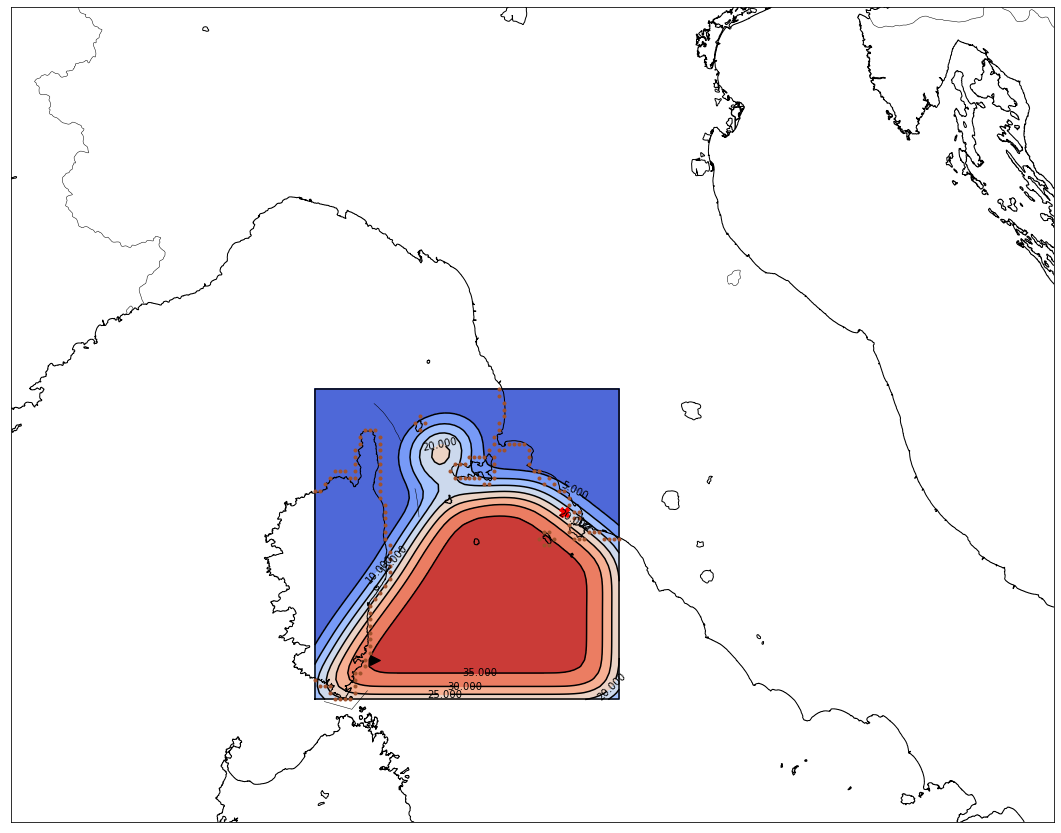

In [109]:
ux = xspace
uy = yspace
uxs, uys = np.meshgrid(ux, uy)
uxs_, uys_ = mp(uxs,uys)
f = [[] for i in range(l)]
for i in range(15):
    positions = np.vstack([uxs.ravel(), uys.ravel()])
    values = np.vstack([oxmeteo[i] + x_obsm[i], oymeteo[i] + y_obsm[i]])
    kernel = st.gaussian_kde(values)
    f[i] = np.reshape(kernel(positions).T, uxs.shape)

f_tot = np.zeros_like(f)
for i in range(l):  
    f_tot[i] = f[i]*100
    
plt.figure(1, figsize=(20, 15))
ax3 = plt.axes()
ax3.contourf(uxs_, uys_, f_tot[0], cmap='coolwarm')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
cset = ax3.contour(uxs_, uys_, f_tot[0], colors='k')
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
ax3.clabel(cset, inline=1, fontsize=10)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [151]:
sx = xspace[12]  
sy = yspace[6] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)
grid_size = 0.04166
q_g = grid_size*5
k_att = 1

xw = 62
yw = 47
print("x_width:", xw)
print("y_width:", yw)

robot_radius = grid_size
ox = x_obsl
oy = y_obsl

x_width: 62
y_width: 47


In [120]:
# calc each potential
def comb_attractive_potential(x, y, gp, q_g):
    d_g = np.sqrt((x - gp[0]) ** 2 + (y - gp[1]) ** 2)
    if d_g <= grid_size:
        d_g = grid_size
    if d_g <= q_g:
        att_pot = 0.5 * k_att * d_g ** 2
    else:
        att_pot = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return att_pot

def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= grid_size/2:
            dq = grid_size/2

        return 0.5 * 10 * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0
    
pmap = [[[0.0 for i in range(xw)] for i in range(yw)] for i in range(l)]

for i in range(l):
    for ix in range(xw):
        x = ix * grid_size + xspace[0]
        for iy in range(yw):
            y = iy * grid_size + yspace[0]
            ug = comb_attractive_potential(x, y, goal, q_g)
#             uo = calc_repulsive_potential(x, y, ox, oy, robot_radius)
            uo_land = calc_repulsive_potential(x, y, x_obsl, y_obsl, robot_radius)/1e2
            uf = ug
            pmap[i][iy][ix] = uf + uo_land
plot_map1 = f_tot + np.array(pmap)

<ipython-input-121-b4919385696f>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1[0], cmap=cm.YlOrBr)


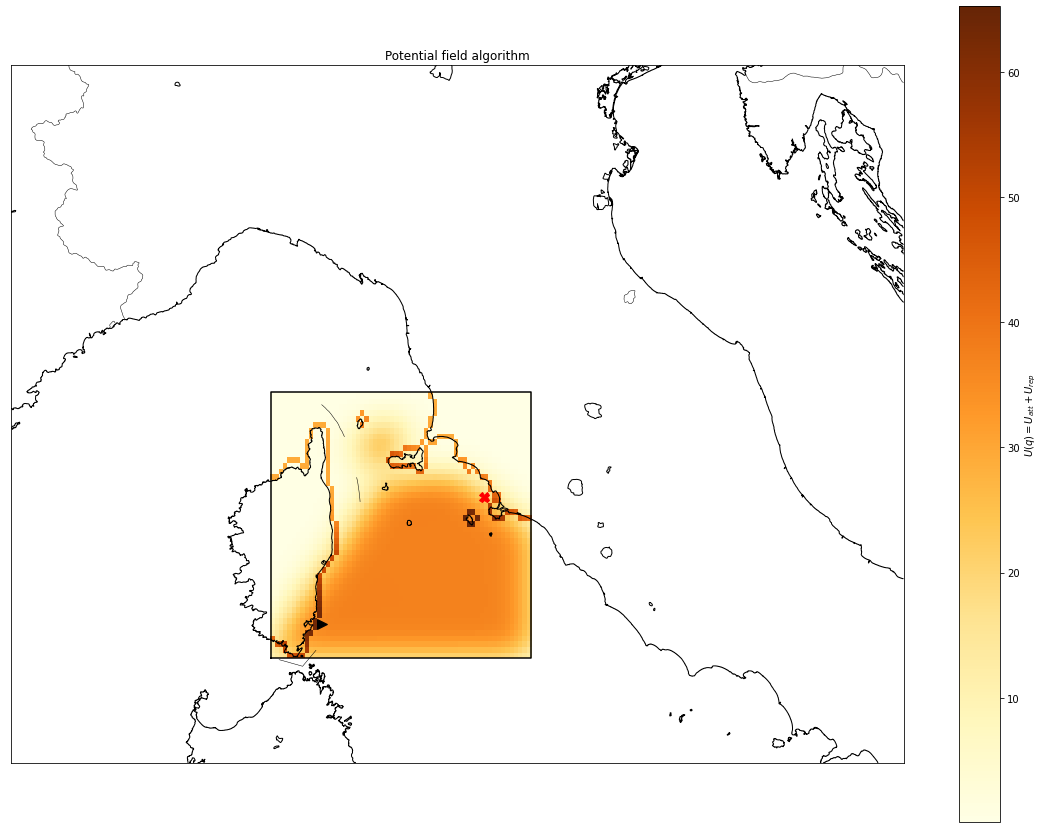

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.pcolor(uxs_, uys_, plot_map1[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

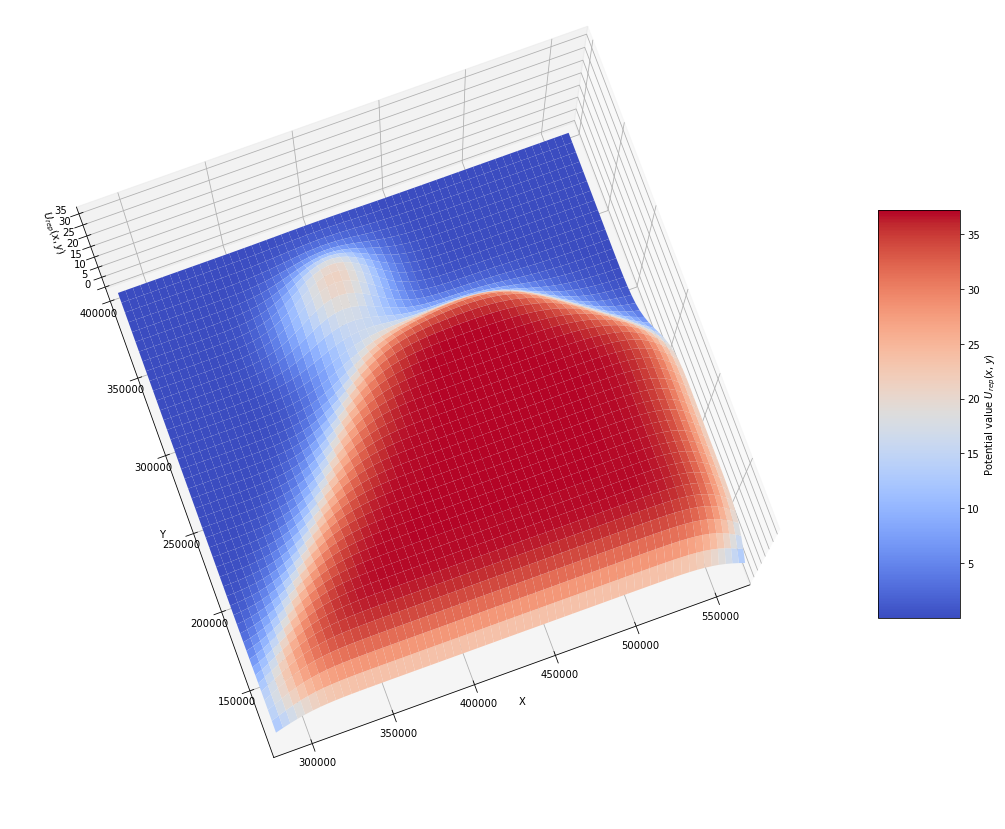

In [145]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(uxs_, uys_, f_tot[0], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(80, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
plt.show()

In [173]:
def calc_dist_from_start(x, y, s):
    a1 = mp(s[0], s[1], inverse=True)
    b1 = mp(x, y, inverse=True)
    
    return distance(lonlat(*a1), lonlat(*b1)).m

def get_motion_model():
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False


def potential_field_planning(s, g, reso, rr, xm, ym, pmap):
    d = np.hypot(s[0] - g[0], s[1] - g[1])
    ix = round((s[0] - xm) / reso)
    iy = round((s[1] - ym) / reso)
    gix = round((g[0] - xm) / reso)
    giy = round((g[1] - ym) / reso)

    rx, ry = [s[0]], [s[1]]
    motion = get_motion_model()
    previous_ids = deque()
    
    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if iny >= len(pmap[0]) or inx >= len(pmap[0][0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[0][inx][iny]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + xm
        yp = iy * reso + ym
        d = np.hypot(g[0] - xp, g[1] - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break
    
    distance = calc_dist_from_start(xp, yp, s)
        
    if d < grid_size:
        print("The robot is arrived at the final point!")
    else:
        print("The robot got lost!")

    return rx, ry, d, distance

In [179]:
d = np.hypot(start[0] - goal[0], start[1] - goal[1])
print("Distance from start to goal is: " + str(d))

dist_tot = 0
k = 1
start_time = time.time()
path_x, path_y, d_update, new_distance = potential_field_planning(start, goal, grid_size, robot_radius, xspace[0], yspace[0], plot_map1)
print("Computational time is {} seconds".format(round(time.time() - start_time,5)))

Distance from start to goal is: 1.8295408
outside potential!
outside potential!
outside potential!
outside potential!
outside potential!
outside potential!
outside potential!
outside potential!
outside potential!
Oscillation detected at (30,8)!
The robot got lost!
Computational time is 0.00431 seconds


In [183]:
path_x_, path_y_ = mp(path_x, path_y)

<ipython-input-184-41fa5058af8b>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1[0], cmap=cm.YlOrBr)


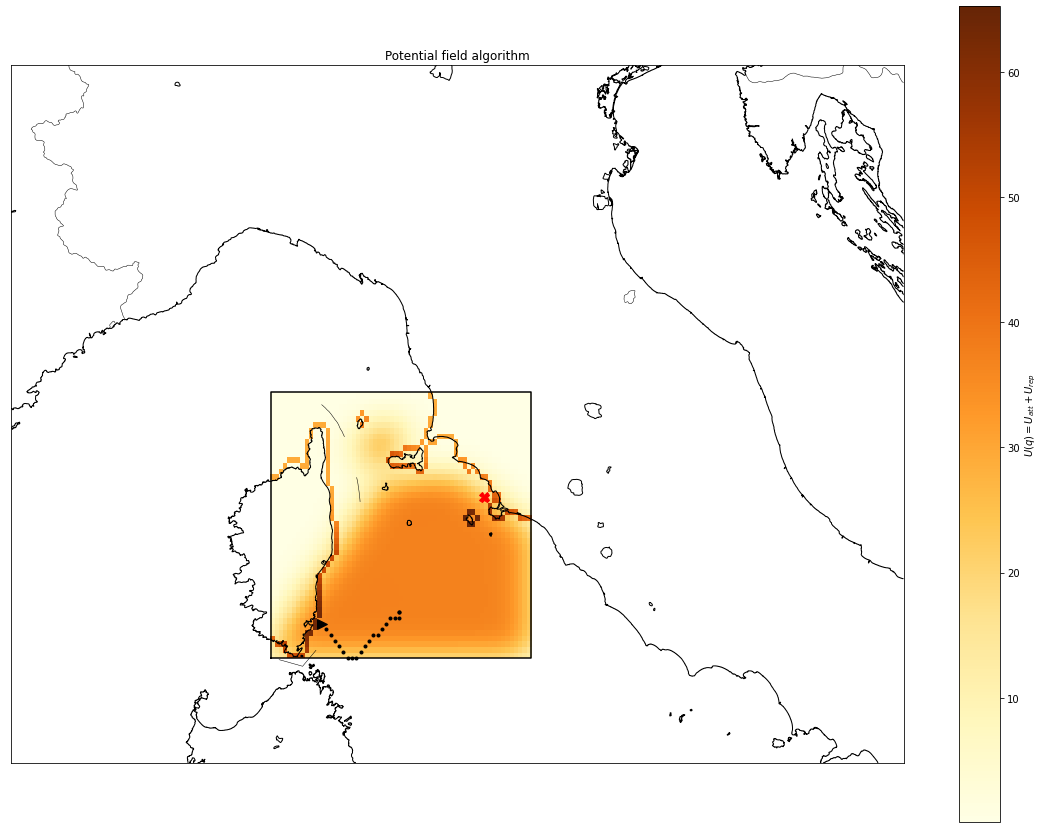

In [184]:
fig1 = plt.figure(1, figsize=(20, 15))
ax = fig1.add_subplot()
plt.pcolor(uxs_, uys_, plot_map1[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(path_x_, path_y_, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

# Attempt with force field

In [82]:
obs = [[] for i in range(l)]
for i in range(l):
    for j in range(len(oxmeteo[i])):
        obs[i].append([oxmeteo[i][j], oymeteo[i][j]])
    for j in range(len(x_obsl)):
        obs[i].append([x_obsl[j], y_obsl[j]])

obs_ = [[] for i in range(l)]
for i in range(l):
    for j in range(len(oxmeteo_[i])):
        obs_[i].append([oxmeteo_[i][j], oymeteo_[i][j]])
    for j in range(len(x_obsl_)):
        obs_[i].append([x_obsl_[i], y_obsl_[i]])

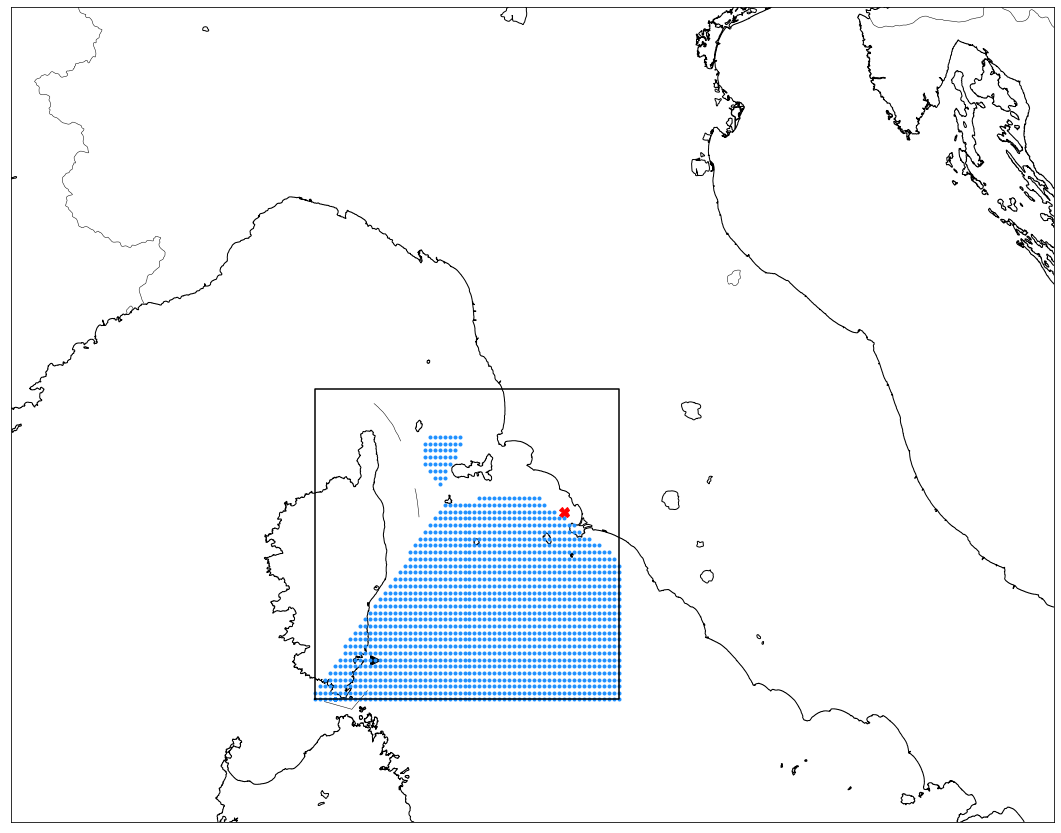

In [83]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obs_[0])):
    plt.plot(obs_[0][i][0], obs_[0][i][1],'.', color="dodgerblue")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [78]:
from APF3 import Vector2d, APF
from APF3_improved import APF_Improved

In [80]:
sx = xspace[12]  
sy = yspace[6] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)
grid_size = 0.04166
q_g = grid_size*5
k_att = 300

robot_radius = grid_size

k_att, k_rep = 1.0, 10.0
rr = grid_size
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*3

apf = APF_Improved(start, goal, obs[0], k_att, k_rep, rr, step_size, max_iters, goal_threshold, False)
apf.path_plan()
if apf.is_path_plan_success:
    path = apf.path
    path_ = []
    i = int(step_size_ / step_size)
    while i < len(path):
        path_.append(path[i])
        i += int(step_size_ / step_size)
    if path_[-1] != path[-1]:  # 添加最后一个点
        path_.append(path[-1])
    print('planed path points:{}'.format(path_))
    print('path plan success')
else:
    print('path plan failed')

TypeError: 'NoneType' object is not subscriptable

In [74]:
pathgeo = []
for i in range(len(path)):
    tempx, tempy = mp(path[i][0],path[i][1])
    pathgeo.append([tempx,tempy])
    
path_dist = 0
for i in range(len(path)-1):
    path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
                          lonlat(*(path[i+1][0],path[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  16.775 hours


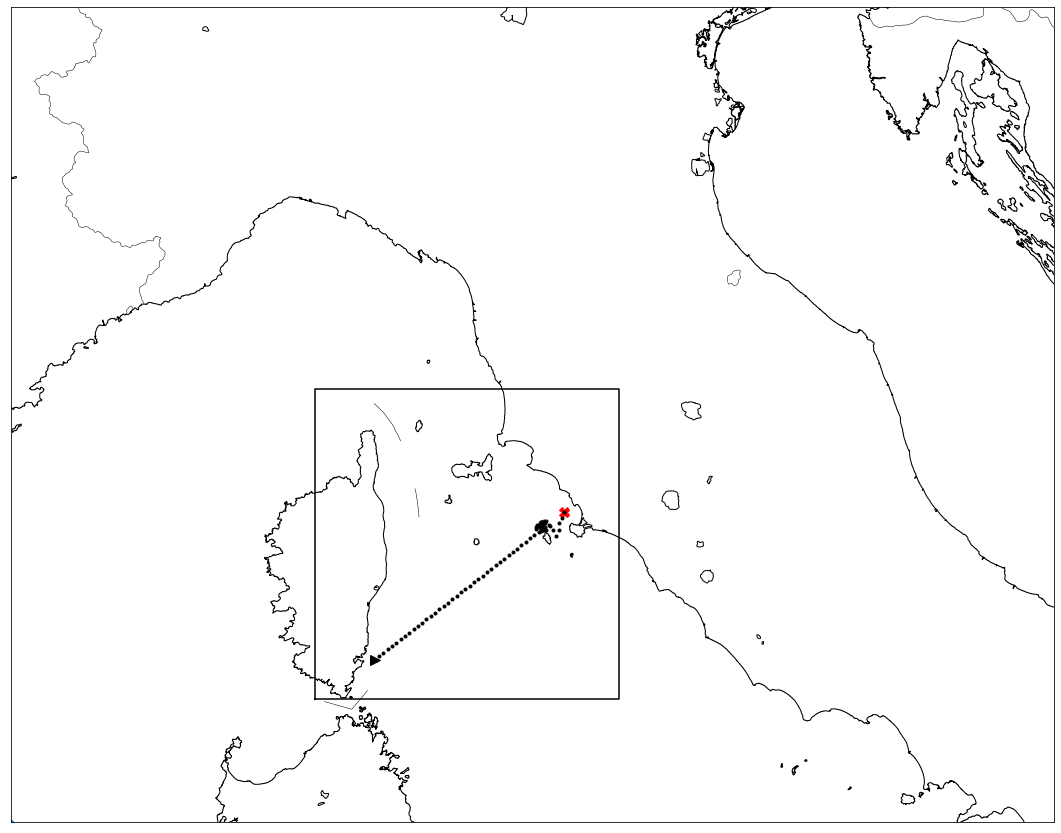

In [75]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(pathgeo)):
    plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()


# APF angles

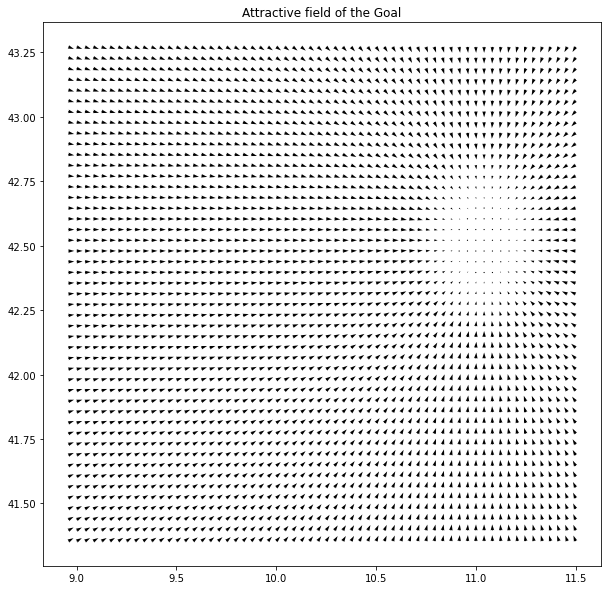

In [320]:
xspace = lons.values
yspace = lats.values

yy = np.arange(0, uys_.shape[0], 1)
xx = np.arange(0, uxs_.shape[1], 1)
points = np.meshgrid(yy, xx)

uxs, uys = np.meshgrid(xspace, yspace)
uxs_, uys_ = mp(uxs, uys)
delx = np.zeros_like(uxs)
dely = np.zeros_like(uys)
gx = xspace[50]
gy = yspace[28]
goal = (gx, gy)

s = 7*grid_size
r = 2*grid_size
for i in range(len(yspace)):
    for j in range(len(xspace)):
        d= np.sqrt((uxs[i][j]-goal[0])**2 + (uys[i][j]-goal[1])**2)

        # calCulating the Theta
        theta = np.arctan2(goal[1] - uys[i][j], goal[0] - uxs[i][j])

        # Using the equations given in the class
        if d < r:
            delx[i][j] = 0
            dely[i][j] = 0
        elif d > (s+r):
            delx[i][j] = 50 * s *np.cos(theta)
            dely[i][j] = 50 * s *np.sin(theta)
        else:
            delx[i][j] = 50 * (d-r) * np.cos(theta)
            dely[i][j] = 50 * (d-r) * np.sin(theta)

fig, ax = plt.subplots(figsize = (10,10))
#mp.quiver(uxs_[points], uys_[points], delx[points], dely[points],width=0.001, color='k')
# ax.quiver(uxs_, uys_, delx, dely)
ax.quiver(uxs, uys, delx, dely)
#ax.add_patch(plt.Circle((0, 0), 2, color='b'))
#ax.annotate("Goal", xy=(0, 0), fontsize=20, ha="center")
ax.set_title('Attractive field of the Goal')
# mp.drawcoastlines()
# mp.drawstates()
# mp.drawcountries()
plt.show() 

## Limit cycles APF

In [669]:
# from APF3 import APF, Vector2d
# import matplotlib.pyplot as plt
# import math
# from matplotlib.patches import Circle
# import random


# def check_vec_angle(v1: Vector2d, v2: Vector2d):
#     v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
#     angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
#     return angle


# class APF_Improved(APF):
#     def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
#                  step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
#         self.start = Vector2d(start[0], start[1])
#         self.current_pos = Vector2d(start[0], start[1])
#         self.goal = Vector2d(goal[0], goal[1])
#         self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
#         self.k_att = k_att
#         self.k_rep = k_rep
#         self.rr = rr  
#         self.step_size = step_size
#         self.max_iters = max_iters
#         self.iters = 0
#         self.goal_threshold = goal_threshold
#         self.path = list()
#         self.is_path_plan_success = False
#         self.is_plot = is_plot
#         self.delta_t = 0.01

#     def repulsion(self):
#         """
#         斥力计算, 改进斥力函数, 解决不可达问题
#         :return: 斥力大小
#         """
#         rep = Vector2d(0, 0) 
#         for obstacle in self.obstacles:
#             obs_to_rob = self.current_pos - obstacle
#             rob_to_goal = self.goal - self.current_pos
#             obs_to_goal = self.goal - obstacle
#             if obs_to_rob.length > self.rr:  
#                 pass
#             else:

#                 """rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
#                         1.0 / obs_to_rob.length - 1.0 / self.rr) / (obs_to_rob.length ** 2) * (rob_to_goal.length ** 2)
#                 rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * ((1.0 / obs_to_rob.length - 1.0 / self.rr) ** 2) * rob_to_goal.length
#                 rep +=(rep_1+rep_2)"""

#                 #rep += Vector2d(+obs_to_rob.direction[1], -obs_to_rob.direction[0]) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(9 - (obs_to_rob.deltaX)**2 - (obs_to_rob.deltaY)**2)
#                 #if obs_to_goal <
#                 rep = (Vector2d(+obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(self.rr**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*200# *(1 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)
#                 if self.current_pos.deltaX < 9.5 or self.current_pos.deltaY > 42.6:
#                     rep = (Vector2d(-obs_to_rob.deltaY, +obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*(self.rr ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 50
#         return rep

In [1411]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time


class Vector2d:
    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF:

    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start: 起点
        :param goal: 终点
        :param obstacles: 障碍物列表，每个元素为Vector2d对象
        :param k_att: 引力系数
        :param k_rep: 斥力系数
        :param rr: 斥力作用范围
        :param step_size: 步长
        :param max_iters: 最大迭代次数
        :param goal_threshold: 离目标点小于此值即认为到达目标点
        :param is_plot: 是否绘图
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
    def attractive(self):
        att = (self.goal - self.current_pos) * self.k_att  # conical potential
        return att

    def repulsion(self):
        rep = Vector2d(0, 0)
        for obstacle in self.obstacles:
            # obstacle = Vector2d(0, 0)
            t_vec = self.current_pos - obstacle
            if t_vec.length > self.rr:
                pass
            else:
                rep += Vector2d(t_vec.direction[0], t_vec.direction[1]) * self.k_rep * (
                        1.0 / t_vec.length - 1.0 / self.rr) / (t_vec.length ** 2)  # 方向由障碍物指向机器人
        return rep

    def path_plan(self):
        while self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threshold:
            
            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])
#             print(self.current_pos.deltaX,self.current_pos.deltaY)
            if self.is_plot:
                plt.plot(self.current_pos.deltaX, self.current_pos.deltaY, '.b')
                plt.pause(self.delta_t)
        if (self.current_pos - self.goal).length <= self.goal_threshold:
            self.is_path_plan_success = True
            

In [1412]:
def check_vec_angle(v1: Vector2d, v2: Vector2d):
    v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
    angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
    return angle


class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
        
    def repulsion(self):
        """
        #斥力计算, 改进斥力函数, 解决不可达问题
        #:return: 斥力大小
        """
        rep = Vector2d(0, 0) 
        obstacle = Vector2d(0, 0)
        list_dro = []  # list of distance robot-obstacle
        list_obs = []  # list of potentially disturbing obstacles
        
        for obstacle in self.obstacles:
            obs_to_rob = self.current_pos - obstacle
            if obs_to_rob.length < self.rr: 
                list_dro.append(obs_to_rob.length)
                list_obs.append(obstacle)
        if len(list_obs) == 0:  # no disturbing obstacles -> controller OFF
            rep = Vector2d(0, 0)
            return rep
        min_d_ro = min(list_dro)
        temp = list_dro.index(min_d_ro)
        closest_obs = list_obs[temp]
        
        obs_to_rob = self.current_pos - closest_obs
        
                
        """rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
                1.0 / obs_to_rob.length - 1.0 / self.rr) / (obs_to_rob.length ** 2) * (rob_to_goal.length ** 2)
        rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * ((1.0 / obs_to_rob.length - 1.0 / self.rr) ** 2) * rob_to_goal.length
        rep +=(rep_1+rep_2)"""

                #rep += Vector2d(+obs_to_rob.direction[1], -obs_to_rob.direction[0]) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(9 - (obs_to_rob.deltaX)**2 - (obs_to_rob.deltaY)**2)
                #if obs_to_goal <
        rep = (Vector2d(-obs_to_rob.deltaY, +obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(self.rr**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*500# *(1 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)
#         if self.current_pos.deltaX < 10:
#             rep = (Vector2d(+obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*(self.rr ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 1000
        return rep

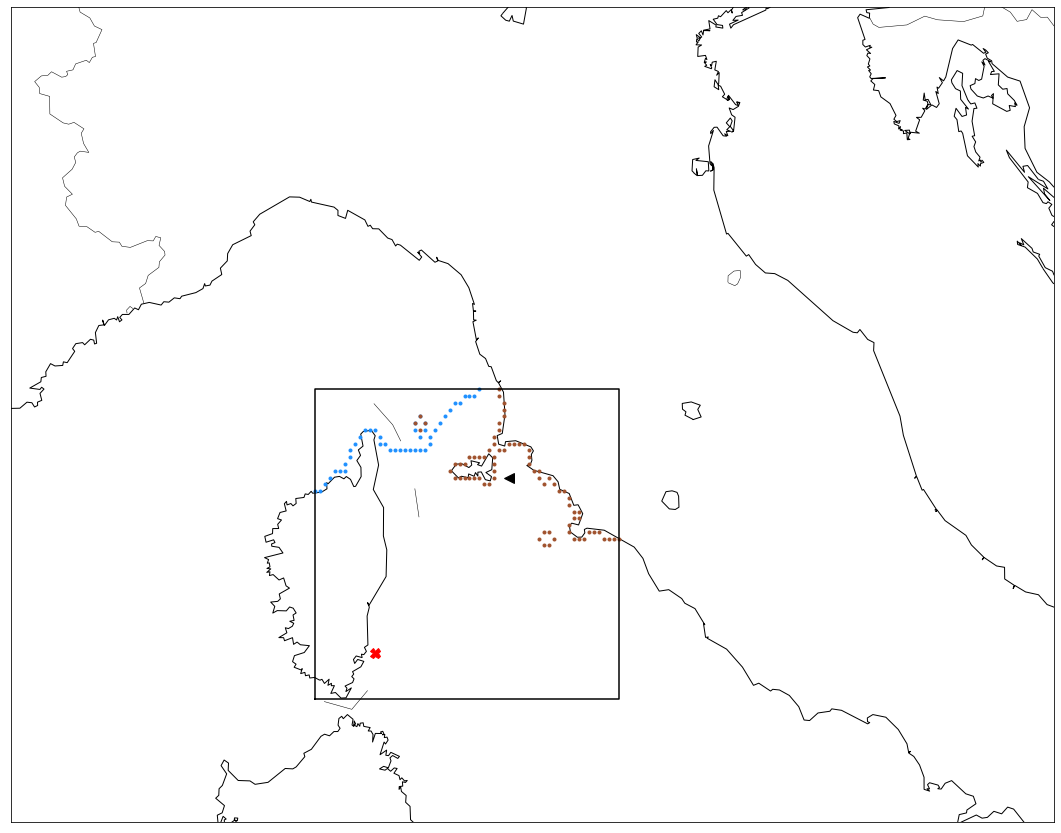

In [1413]:
r=0
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, "<k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsm_[r], y_obsm_[r], '.', color="dodgerblue")
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [105]:
# start_time = time.time()
# apf = APF_Improved(start, goal, obs[5], 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
# apf.path_plan()
# print("Computational time is {} seconds".format(time.time() - start_time))

# path = apf.path

# if apf.is_path_plan_success:
#     print('path plan success')
# else:
#     print('path plan failed')

# pathgeo = []
# for i in range(len(path)):
#     tempx, tempy = mp(path[i][0],path[i][1])
#     pathgeo.append([tempx,tempy])
    
# path_dist = 0
# for i in range(len(path)-1):
#     path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
#                           lonlat(*(path[i+1][0],path[i+1][1]))).km
# print("Travel time = ", str(round(path_dist/18,4)), "hours")

In [1462]:
grid_size = 0.04166
rr = grid_size*2
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*2

sx = xspace[39]  
sy = yspace[33] 
gx = xspace[12]   # 50
gy = yspace[7]   # 28
sx_init, sy_init = mp(sx, sy)
sx_a, sy_a = sx_init, sy_init
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)

obs = [[] for i in range(le-li)]
for i in range(le-li):
    for j in range(len(x_obsm[i])):
        obs[i].append([x_obsm[i][j], y_obsm[i][j]])
#     for j in range(len(x_obsl)):
#         obs[i].append([x_obsl[j], y_obsl[j]])
#     for j in range(len(ox_a_list[i])):
#         obs[i].append([ox_a_list[i][j], oy_a_list[i][j]])
        
apfrx_list = []
apfry_list = []
apfrx_list_finale = []
apfrx_list_finale.append(sx)
apfry_list_finale = []
apfry_list_finale.append(sy)
k = 0
path_dist = 0
path_dist_list = []
list_apfsx = []
list_apfsy = []
list_apfsx.append(sx)
list_apfsy.append(sy)
var1 = True
dist = np.hypot(sx - gx, sy - gy)


In [1463]:
start_time = time.time()
while dist >= grid_size:
    path_cost = 0
#     if k == 0:
#         apf = APF_Improved(start, goal, [[0,0]], 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
#         apf.path_plan()
#         path = apf.path
#         rx = list(np.zeros(len(path)))
#         ry = list(np.zeros(len(path)))
#         for i in range(len(path)):
#             rx[i], ry[i] = path[i][0], path[i][1]

#         for i in range(len(rx)-1):
#             path_cost += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
#         print("Travel distance = {} km".format(path_cost))
        
#         q = 0
#         while path_dist < 18*(k+1): # km
#             if np.hypot(rx[q] - gx, ry[q] - gy) <= grid_size:
#                 print("Complete travel in less than {} hours".format(k+1))
#                 dist = np.hypot(rx[q] - gx, ry[q] - gy)
#                 break
#             path_dist += distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
            
#             # to be conservative I rather use future time window than starting in the future with a past map
#             if path_dist > 18*(k+1):  
#                 path_dist -= distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
#                 path_dist_list.append(path_dist)
#                 break 
#             q += 1
            
#         sx = rx[q]
#         sy = ry[q]
#         list_apfsx.append(sx)
#         list_apfsy.append(sy)
#         apfrx_list.append(rx)
#         apfry_list.append(ry)
#         apfrx_list_finale.extend(rx[:q])
#         apfry_list_finale.extend(ry[:q])
# #         ######
#     else:
    apf = APF_Improved(start, goal, obs[k], 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
    apf.path_plan()
    path = apf.path
    rx = list(np.zeros(len(path)))
    ry = list(np.zeros(len(path)))
    for i in range(len(path)):
        rx[i], ry[i] = path[i][0], path[i][1]

    for i in range(len(rx)-1):
        path_cost += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
    print("Travel distance = {} km".format(path_cost))

    if apf.is_path_plan_success:
        print('path plan success')
        q = 0
        while path_dist < 18*(k+1): # km
            if np.hypot(rx[q] - gx, ry[q] - gy) <= grid_size:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(rx[q] - gx, ry[q] - gy)
                break
            path_dist += distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km

            # to be conservative I rather use future time window than starting in the future with a past map
            if path_dist > 18*(k+1):  
                path_dist -= distance(lonlat(*(rx[q],ry[q])), lonlat(*(rx[q+1],ry[q+1]))).km
                path_dist_list.append(path_dist)
                break 
            q += 1

        sx = rx[q]
        sy = ry[q]
        list_apfsx.append(sx)
        list_apfsy.append(sy)
        apfrx_list.append(rx)
        apfry_list.append(ry)
        apfrx_list_finale.extend(rx[:q])
        apfry_list_finale.extend(ry[:q])
    else:
        print("Path plan failed")
        print("The algorithm does not found a path because of rough sea in between or in the survey area")

        q_init = apfrx_list[-1].index(sx)
        q = apfrx_list[-1].index(sx)
        while path_dist < 18*(k+1): # km
            if np.hypot(apfrx_list[-1][q] - gx, apfry_list[-1][q] - gy) <= grid_size:
                print("Complete travel in less than {} hours".format(k+1))
                dist = np.hypot(apfrx_list[-1][q] - gx, apfry_list[-1][q] - gy)
                break
            path_dist += distance(lonlat(*(apfrx_list[-1][q],apfry_list[-1][q])), lonlat(*(apfrx_list[-1][q+1],apfry_list[-1][q+1]))).km
            # to be conservative I rather use future time window than starting in the future with a past map
            if path_dist > 18*(k+1):  
                path_dist -= distance(lonlat(*(apfrx_list[-1][q],apfry_list[-1][q])), lonlat(*(apfrx_list[-1][q+1],apfry_list[-1][q+1]))).km
                path_dist_list.append(path_dist)
                break 
            q += 1

        sx = apfrx_list[-1][q]
        sy = apfry_list[-1][q]
        list_apfsx.append(sx)
        list_apfsy.append(sy)
        apfrx_list.append(apfrx_list[-1])  # resave the same path
        apfry_list.append(apfry_list[-1])
        apfrx_list_finale.extend(apfrx_list[-1][q_init:q])
        apfry_list_finale.extend(apfry_list[-1][q_init:q])

    dist = np.hypot(sx - gx, sy - gy)
#     print(dist)
    start = (sx, sy)
    sx_a, sy_a = mp(sx, sy)
    rx_, ry_ = mp(rx, ry)    

    k += 1
    for i in range(len(meteo[k])):
        if np.allclose([sx,sy], meteo[k][i], atol=0.001, rtol=0.001):
            print(True)
            apfrx_list_finale.append(rx[q])
            apfry_list_finale.append(ry[q])
            print("USV got lost")
            var1 = False
            break
    if var1:
        print("USV in safe zone")
    else:
        break

# rx_list_finale.extend(rx)
# ry_list_finale.extend(ry)
print("Computational time is {}".format(time.time() - start_time))

Travel distance = 146.0074085425508 km
path plan success
USV in safe zone
Travel distance = 125.7811432964145 km
path plan success
USV in safe zone
Travel distance = 105.53788977782972 km
path plan success
USV in safe zone
Travel distance = 81.22359251767594 km
path plan success
USV in safe zone
Travel distance = 60.943043964960744 km
path plan success
USV in safe zone
Travel distance = 36.58405934847179 km
path plan success
USV in safe zone
Travel distance = 16.26632786216574 km
path plan success
Complete travel in less than 7 hours
USV in safe zone
Computational time is 0.27899599075317383


In [1451]:
# k = 5
# for i in range(len(meteo[k])):
#     if np.allclose([list_apfsx[5], list_apfsy[5]], meteo[k][i], atol=0.001, rtol=0.001):
#         print(True)

In [1452]:
# if np.allclose([list_apfsx[1], list_apfsy[1]],[10.250001, 42.354168], atol=0.003, rtol=0.001):
#     print(True)

In [1453]:
# pathgeo = []
# for i in range(len(path)):
#     tempx, tempy = mp(path[i][0],path[i][1])
#     pathgeo.append([tempx,tempy])

In [1468]:
apfrx_list_ = np.zeros_like(apfrx_list)
apfry_list_ = np.zeros_like(apfry_list)
for i in range(len(apfrx_list)):
        apfrx_list_[i],apfry_list_[i] = mp(apfrx_list[i],apfry_list[i])
    
for i in range(len(list_apfsx)):
        list_apfsx_,list_apfsy_ = mp(list_apfsx,list_apfsy)

In [1465]:
print(apfrx_list_finale)
# print(rx)
# print(sx)
gx
# apfrx_list_finale.pop()

[10.583334, 10.55332546291607, 10.52331695671593, 10.49330845051579, 10.46329994431565, 10.40328293191537, 10.37327442571523, 10.34326591951509, 10.31325741331495, 10.25324040091467, 10.223231894714528, 10.193223388514388, 10.163214882314247, 10.133206376114106, 10.073189363713826, 10.043180857513685, 10.013172351313544, 9.983163845113404, 9.923146832713122, 9.893138326512982, 9.86312982031284, 9.8331213141127, 9.80311280791256, 9.743095795512279, 9.713087289312138, 9.683078783111997, 9.653070276911857, 9.593053264511575, 9.563044758311435, 9.533036252111295, 9.503027745911153]


9.458334

In [1051]:
# apfrx_list_finale.append(gx)
# apfry_list_finale.append(gy)

list_apfsx

[10.583334,
 10.422533978738366,
 10.234809813853746,
 10.090791574266222,
 9.94677333467869,
 9.773951447173653,
 9.629933207586122,
 9.485914967998587]

In [1466]:
apfrx_list_finale.pop()
apfrx_list_finale.append(gx)
apfry_list_finale.pop()
apfry_list_finale.append(gy)
# apfry_list_finale.append(sy)

In [1467]:
list_apfsx.pop()
list_apfsy.pop()
list_apfsx.append(gx)
list_apfsy.append(gy)

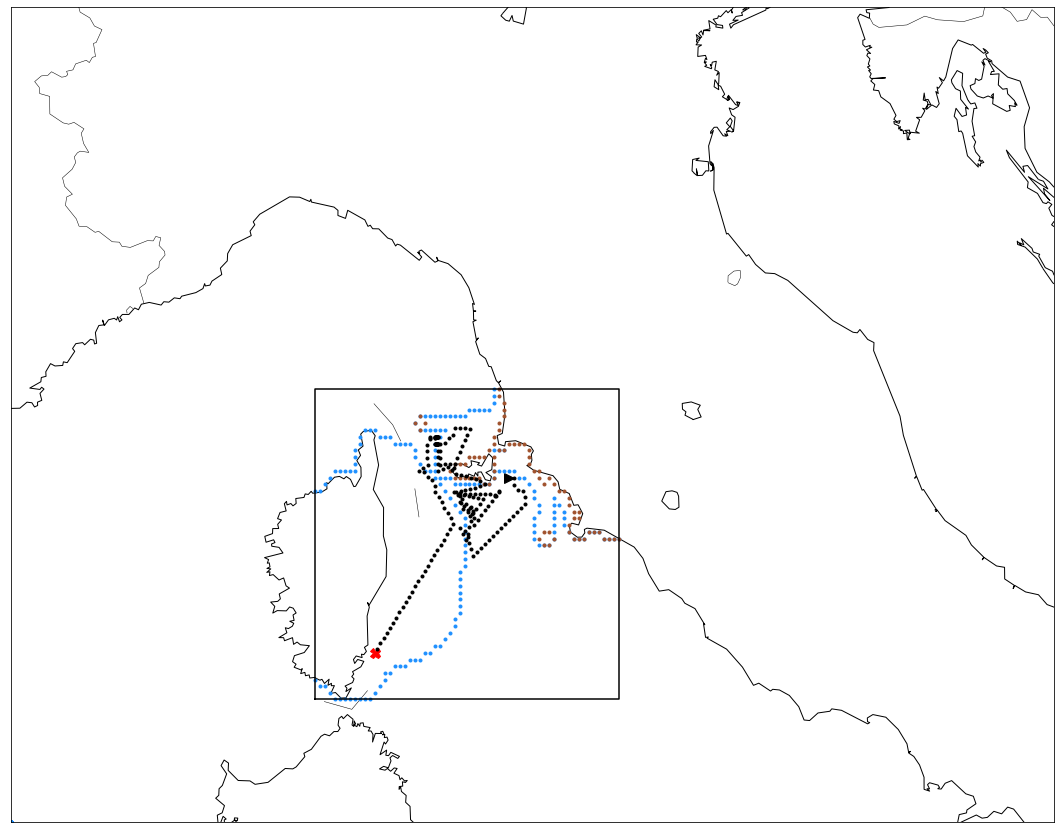

In [1145]:
pathgeo = []
for i in range(len(path)):
    tempx, tempy = mp(path[i][0],path[i][1])
    pathgeo.append([tempx,tempy])
    
# # path_dist = 0
# # for i in range(len(path)-1):
# #     path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
# #                           lonlat(*(path[i+1][0],path[i+1][1]))).km
# # print("Travel time = ", str(round(path_dist/18,4)), "hours")

plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsm_[0], y_obsm_[0], '.', color="dodgerblue")
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
for i in range(len(pathgeo)):
    plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [1521]:
# apfrx_list_finale.append(rx[-1])
# apfry_list_finale.append(ry[-1])

In [1469]:
path_dist = 0
for i in range(len(apfrx_list_finale)-1):
    path_dist += distance(lonlat(*(apfrx_list_finale[i],apfry_list_finale[i])), lonlat(*(apfrx_list_finale[i+1],apfry_list_finale[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  8.4467 hours


In [1306]:
# apfrx_list_finale.append(list_apfsx[-1])
# apfry_list_finale.append(list_apfsy[-1])

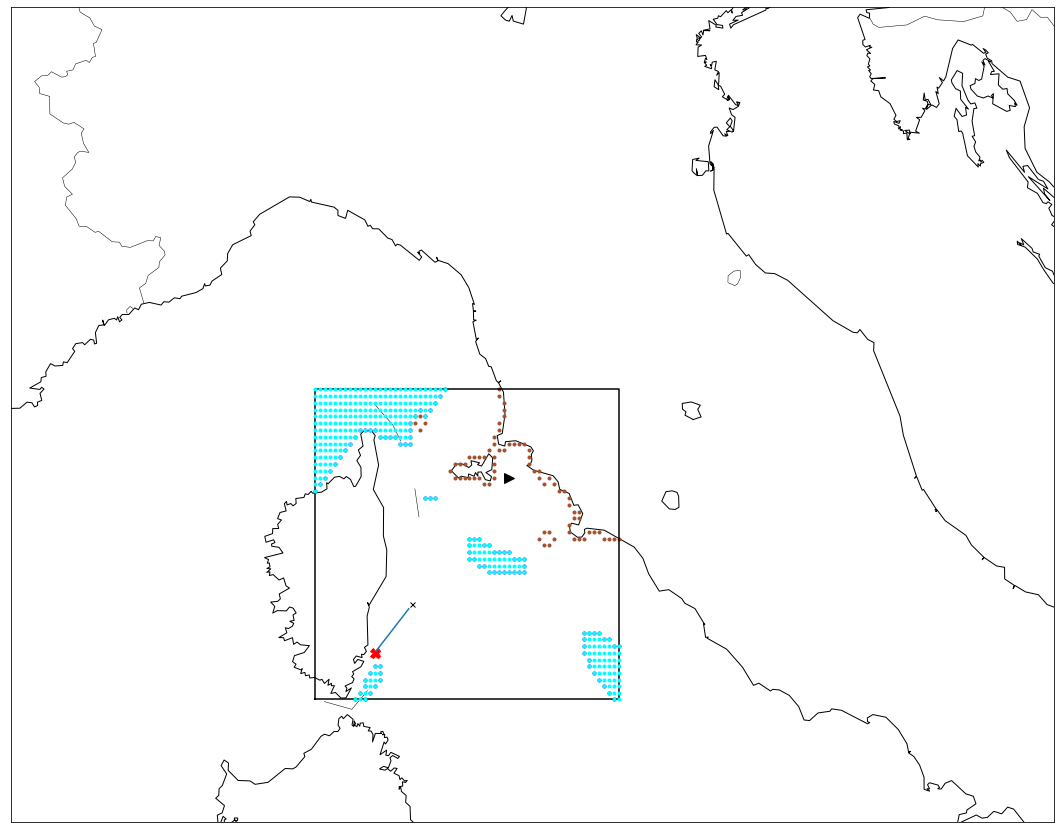

In [1470]:
j=5
plt.figure(1, figsize=(20, 15))
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.plot(sx_init, sy_init, ">k", markersize=10)
# mp.plot(sx_a, sy_a, ".k", markersize=5)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_[j], y_obsm_[j], '.', color="b")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k") 
plt.plot(list_apfsx_[j], list_apfsy_[j], 'xk', markersize=5)
mp.plot(apfrx_list_[j], apfry_list_[j], '-')
plt.plot(oxmeteo_[j], oymeteo_[j], '.', color="aqua")
# plt.plot(list_apfsx_[j], list_apfsy_[j], 'Pk', markersize=10)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [707]:
hh = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(6.42,45.5488))).m / mp(15.13,45.5488)[1])
ww = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(15.13,40.58))).m / mp(15.13,45.5488)[0])

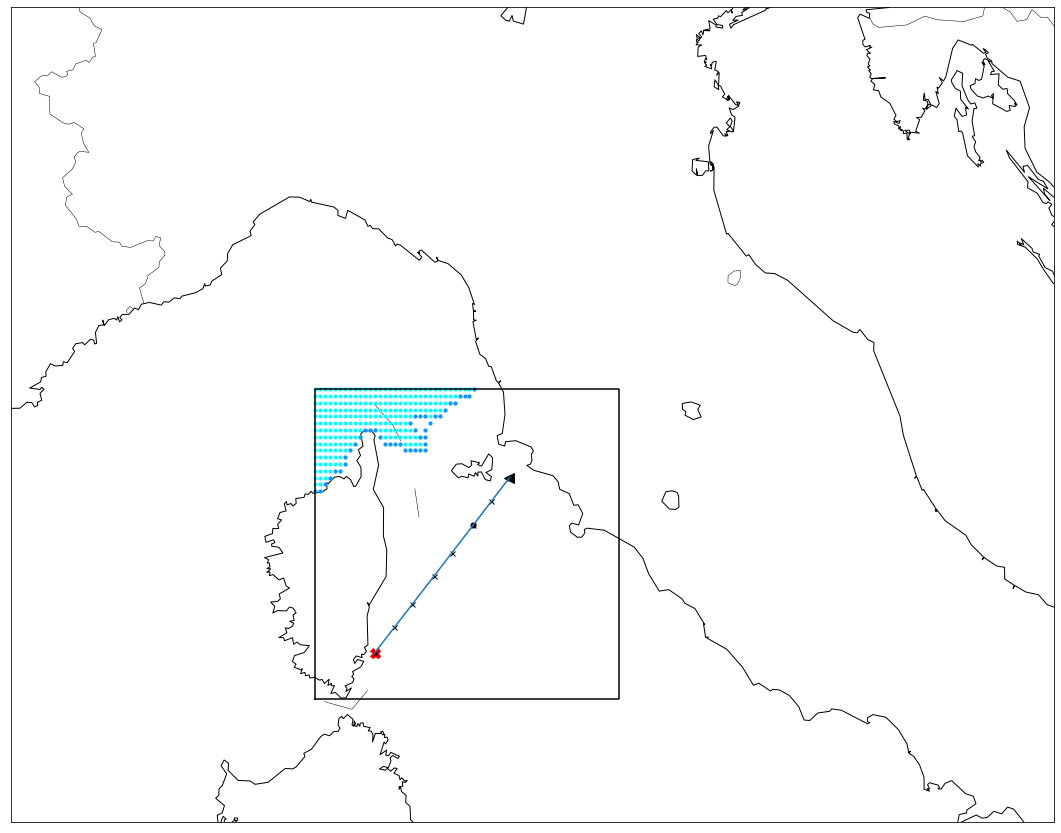

In [1471]:
i =2
apfrx_list_finale_, apfry_list_finale_ = mp(apfrx_list_finale, apfry_list_finale)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, "<k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(oxmeteo_[i], oymeteo_[i], '.', color="aqua")
# mp.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'red']))
# plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_[i], y_obsm_[i], '.', color="dodgerblue")
# mp.plot(apfrx_list_[i], apfry_list_[i], '-')
plt.plot(list_apfsx_, list_apfsy_, 'xk', markersize=5)
plt.plot(list_apfsx_[i], list_apfsy_[i], '.k', markersize=10)
mp.plot(apfrx_list_finale_, apfry_list_finale_, '-')
#plt.plot(list_apfsx_[i], list_apfsy_[i], 'Pk', markersize=15)
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# mp.plot(temp, temp2, '-')
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
# mp.plot(rx_ob[0], ry_ob[0], "Xr", markersize=10)
# plt.scatter(local_x_2, local_y_2, color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [143]:
rx_ob = []
ry_ob = []
for i in range(len(local_x2)):              
    for j in range(len(apfrx_list_finale)):
        if np.allclose([apfrx_list_finale[j],apfry_list_finale[j]], [local_x2[i], local_y2[i]], atol=0.0001, rtol=0.0008): # tune parameters 0.02058
            print(True)  
            rx_ob.append(apfrx_list_finale[j])
            ry_ob.append(apfry_list_finale[j])



True


In [151]:
temp =  apfrx_list_finale[:apfrx_list_finale.index(rx_ob[0])+1]
temp2 = apfry_list_finale[:apfrx_list_finale.index(rx_ob[0])+1]

templistx = list_apfsx[:4]
templisty = list_apfsy[:4]
templistx.append(rx_ob[0])
templisty.append(ry_ob[0])



In [714]:
# gloapf50 = [[] for i in range(12)]
# gloapf39 = [[] for i in range(12)]

# apf_list_s50 = [[] for i in range(12)] 
# apf_list_s39 = [[] for i in range(12)]  

In [1461]:
gloapf50[11] = [apfrx_list_finale, apfry_list_finale]
apf_list_s50[11] = [list_apfsx, list_apfsy]

In [1472]:
gloapf39[11] = [apfrx_list_finale, apfry_list_finale]
apf_list_s39[11] = [list_apfsx, list_apfsy]

In [1502]:
# gloapf1.append([apfrx_list_finale, apfry_list_finale])
# apf_list_s1.append([list_apfsx, list_apfsy])

In [1476]:
import pickle
file_name = "apf_list_s39.pkl"
open_file = open(file_name, "wb")
pickle.dump(apf_list_s39, open_file)
open_file.close()

# file_name = "gloapf1.pkl"
# open_file = open(file_name, "rb")
# gloapf1 = pickle.load(open_file)
# open_file.close()

In [1440]:
gloapf1 = [[] for i in range(5)]  # 5 for 5 day missions
gloapf2 = [[] for i in range(5)]

apf_list_s1 = [[] for i in range(5)]  # 5 for 5 day missions
apf_list_s2 = [[] for i in range(5)]  # 5 for 5 day missions

In [140]:
gloapf2[4] = [apfrx_list_finale, apfry_list_finale]
apf_list_s2[4] = [list_apfsx, list_apfsy]